In [1]:
suppressPackageStartupMessages(library(rstanarm))
suppressPackageStartupMessages(library(ggformula))
library(tibble)
suppressPackageStartupMessages(library(glue))
suppressPackageStartupMessages(library(dplyr))
library(stringr)

In [2]:
# Set the maximum number of columns and rows to display
options(repr.matrix.max.cols=150, repr.matrix.max.rows=200)
# Set the default plot size
options(repr.plot.width=18, repr.plot.height=12)

In [3]:
download_if_missing <- function(filename, url) {
    if (!file.exists(filename)) {
        dir.create(dirname(filename), showWarnings=FALSE, recursive=TRUE)
        download.file(url, destfile = filename, method="curl")
    }
}

# Prediction for a comparison

A linear regression is fit on high school students modeling grade point averge given household income.
Write R code to compute the 90% predictive interval for the difference in grade point average comparing two students, one with household income of \\$40 000 and one with household income of \\$80 000.

First simulate some fake data for illustration purposes.

Let's suppose an increase in income in \\$20k corresponds to a 2 point increase in GPA, and that income is normally distributed with mean \\$60k, and standard deviation \\$20k.
To make numbers nicer express all incomes in thousands of dollars.

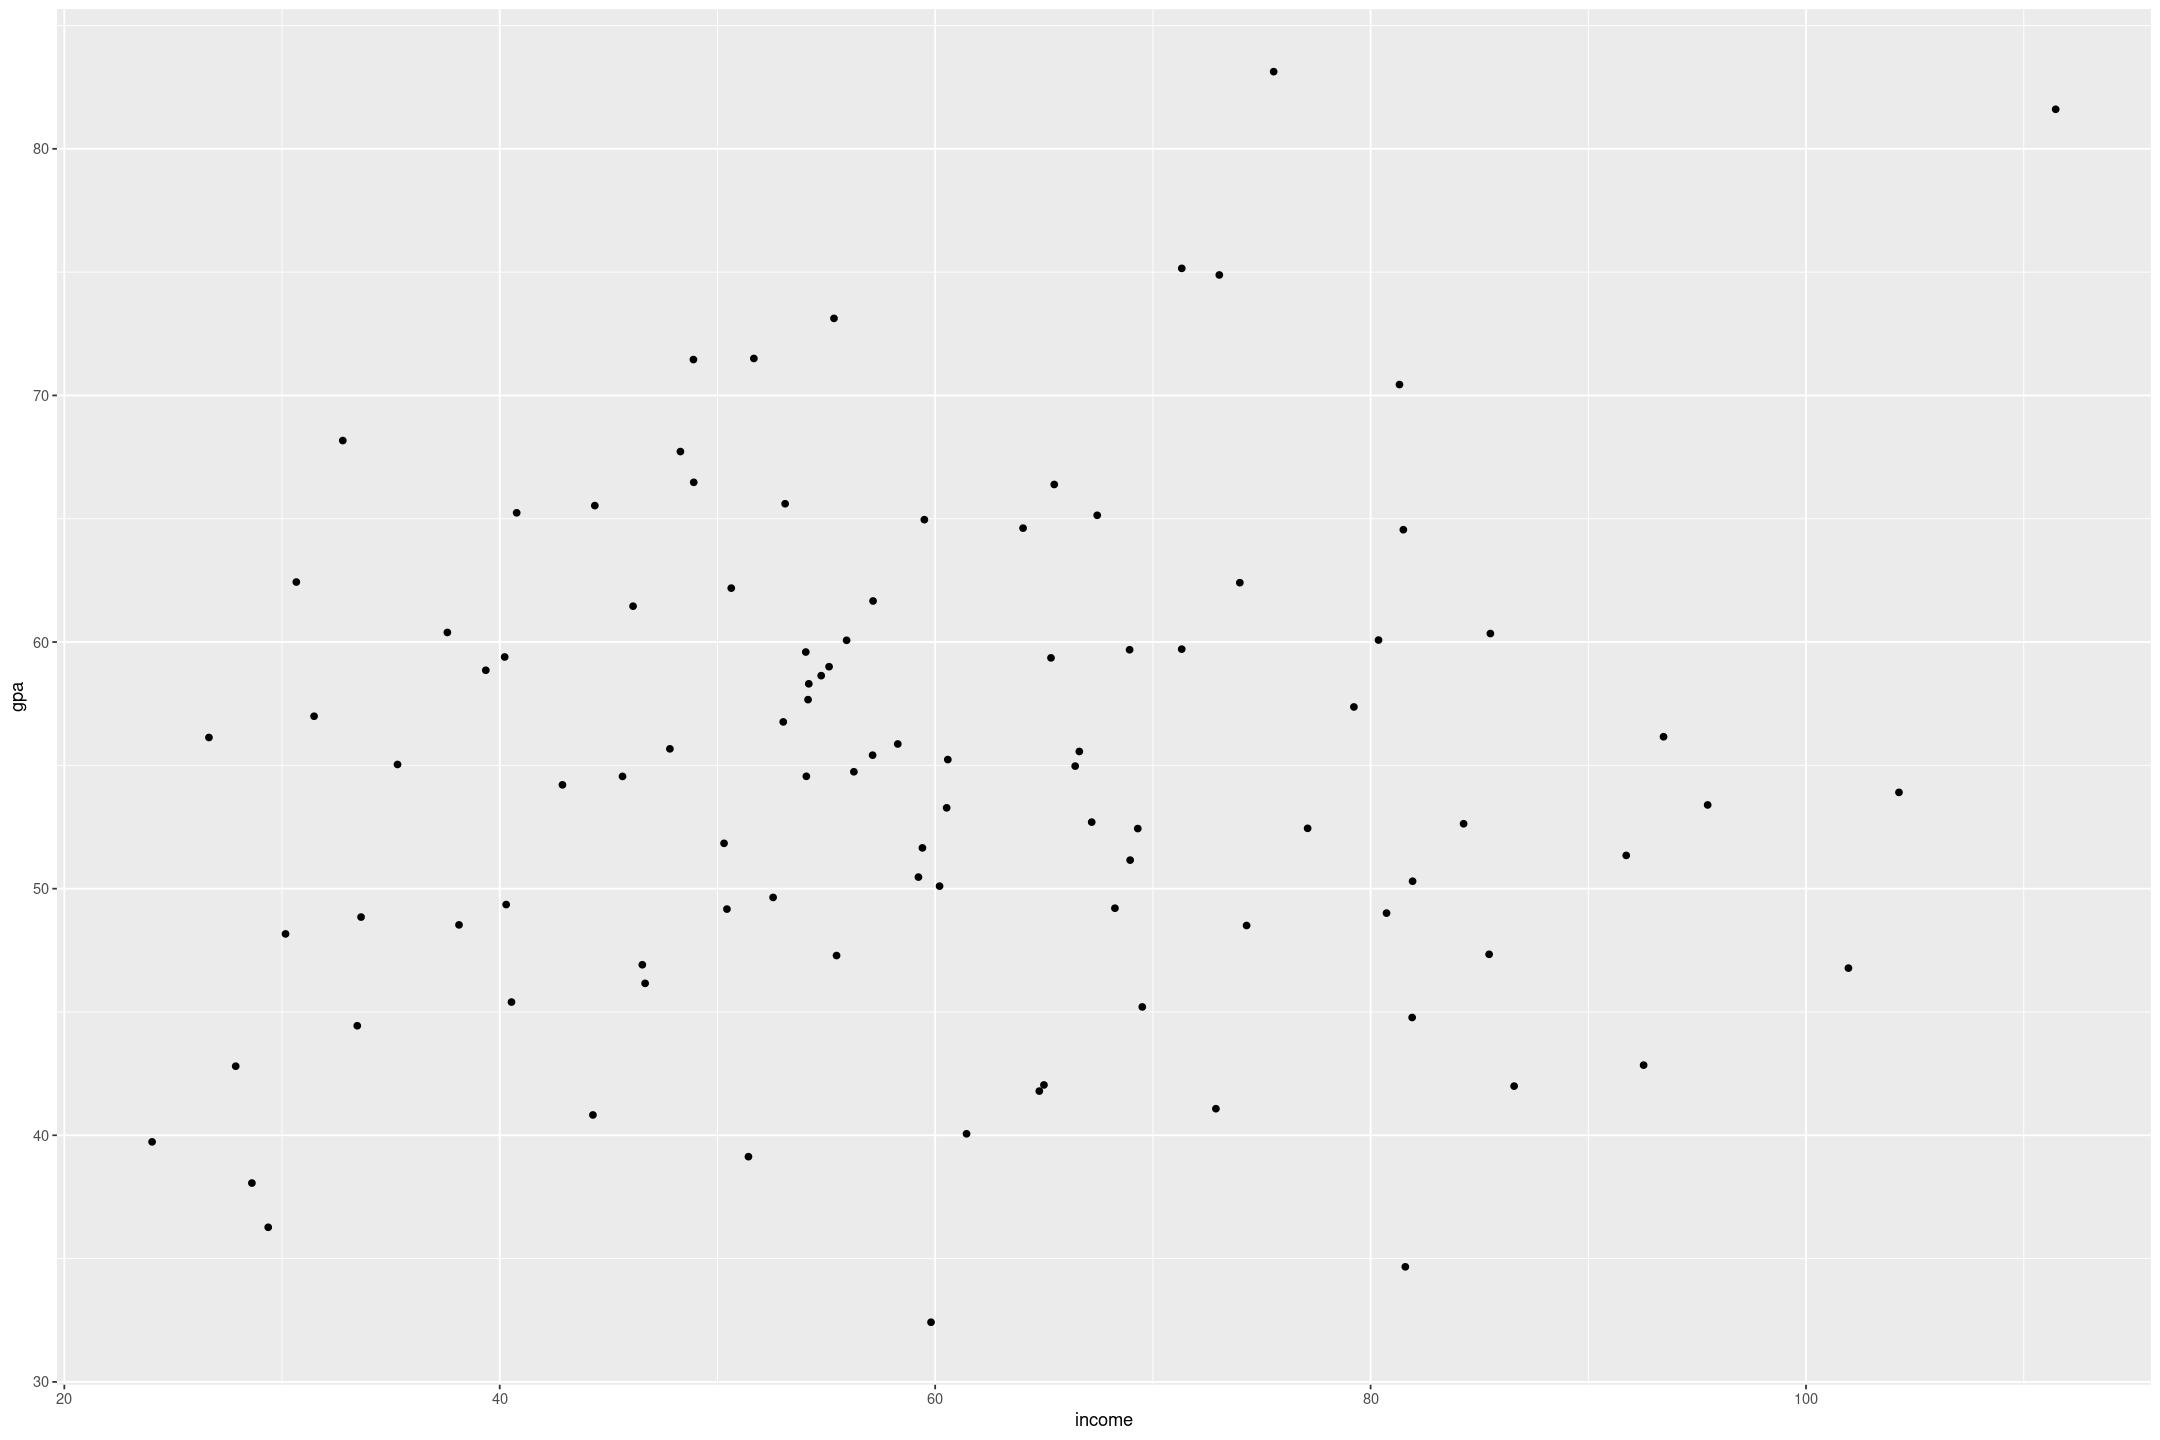

In [4]:
n_sample <- 100

fake_income <- rnorm(n_sample, 60, 20)
fake_gpa <- 50 + (2/20) * fake_income + rnorm(n_sample, 0, 10)

fake_high_school <- tibble(income=fake_income, gpa=fake_gpa)

fake_high_school %>% gf_point(gpa ~ income)

Fit a linear model

It's in the right ballpark

In [5]:
fake_high_school_lm <- stan_glm(gpa ~ income, data=fake_high_school, refresh=0)

fake_high_school_lm

stan_glm
 family:       gaussian [identity]
 formula:      gpa ~ income
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept) 51.7    3.3  
income       0.1    0.1  

Auxiliary parameter(s):
      Median MAD_SD
sigma 10.0    0.7  

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

In [6]:
coef(fake_high_school_lm)

(Intercept)      income 
51.67575299  0.05453178

To calculate the 90% predictive interval in the difference in GPA between students with household incomes of \\$40k and \\$80k respectively, first we simulate what their GPA would be.

Note we use `posterior_predict`; that is we simulate the data points as `y = a + bx + error`.
So this answers the question: if we were to measure the difference in GPA between the students, what region do we expect the measurement to lie with 90% certainty?

In [7]:
sim_gpas <- posterior_predict(fake_high_school_lm, newdata=tibble(income=c(40, 80)))

sim_gpas %>% t()

1,61.88638,63.96334,34.73864,57.87176,53.92293,60.66733,52.95808,44.05034,61.40947,67.38322,52.68335,62.68202,65.69782,48.86207,52.96247,45.65322,76.31728,54.25946,50.08926,62.87318,72.89275,28.37298,54.32276,57.68029,50.11120,59.65379,57.26912,60.00518,67.14841,55.23418,60.60574,71.06234,41.6771,61.08616,59.67982,74.95109,64.74932,45.86523,56.56248,51.60312,57.42402,50.14361,43.82386,56.46758,44.76232,44.75122,47.00644,53.76803,59.37850,46.99802,57.42326,46.48123,51.05461,48.48972,48.27730,53.07274,52.96019,33.94409,46.56687,66.66933,50.75709,49.93680,49.53645,62.51107,54.00223,47.42832,63.77529,56.87335,56.76769,71.50631,54.67849,55.19788,58.74223,50.91994,43.86162,⋯,61.06910,72.23657,57.03362,78.04243,54.23906,39.51404,58.82087,59.05521,56.58515,47.40216,51.07023,66.30161,61.25878,55.46307,61.91454,34.17282,69.52689,61.17385,55.35641,70.11389,63.80480,64.98461,37.63687,63.00874,57.27580,48.46361,57.75482,62.29033,28.66317,59.79981,68.50565,42.77257,55.06774,54.77813,71.48789,41.98193,48.76298,54.04235,42.74755,56.05167,55.16870,51.25380,45.24486,40.43484,46.26644,52.57167,69.95617,55.23052,58.59266,49.74122,58.96036,57.4659,41.43412,52.27890,56.09750,52.93426,53.40245,71.20018,39.31666,73.83205,39.03873,53.54539,43.22882,46.89069,39.43004,65.58600,36.22230,39.91814,70.78126,71.59049,62.67391,43.96335,51.66557,51.58447,45.65029
2,59.30116,68.33584,56.57450,43.30180,28.57032,50.41827,58.99593,48.90820,57.72793,54.22455,49.44277,78.44262,52.68871,65.96557,64.74955,50.32138,67.56537,47.48361,65.84502,49.50065,33.55313,76.98753,33.17323,78.81663,51.15531,54.94355,41.59967,42.99034,53.82825,65.53588,51.93006,12.27202,61.2372,45.48858,70.44345,63.23875,74.09383,45.68605,67.02532,68.61466,61.73602,61.67554,63.04228,68.48388,60.94237,57.02808,74.00926,52.26575,36.18486,74.40706,35.31855,48.96851,66.41201,73.06491,63.39547,63.39136,52.32348,36.66458,53.12122,54.43701,53.34343,50.85088,54.89664,46.28999,42.60037,50.73061,67.84850,55.79985,47.44763,59.22972,63.11826,49.23478,49.93117,61.95149,53.47809,⋯,67.66441,57.48151,57.05973,53.91146,48.63598,44.98666,59.35604,53.52327,42.72840,51.80132,46.14591,70.31100,50.51561,45.89749,57.57280,58.77547,50.36011,62.25590,69.25428,73.29353,56.68333,50.38511,47.99939,62.19797,41.91811,69.30017,48.72781,53.75641,76.53581,63.07902,57.17847,80.80276,53.85676,61.41044,47.76775,60.86802,58.88618,64.86551,59.26809,51.92142,49.91715,51.85241,70.45124,51.32363,78.87360,51.88948,32.04177,66.06366,48.56462,60.53269,53.14679,58.4111,43.05288,51.61079,46.82173,40.90472,67.90841,77.84536,51.85118,63.74997,71.49171,63.83468,42.96873,55.88283,48.34975,69.88266,63.65853,42.03230,44.98008,49.43234,77.83322,62.24115,56.26316,60.54229,51.90210


Next we calculate the difference for each simulation draw, here calculating (gpa @ \\$40k) - (gpa @ \\$80k)

In [8]:
sim_diffs <- sim_gpas[,1] - sim_gpas[,2]

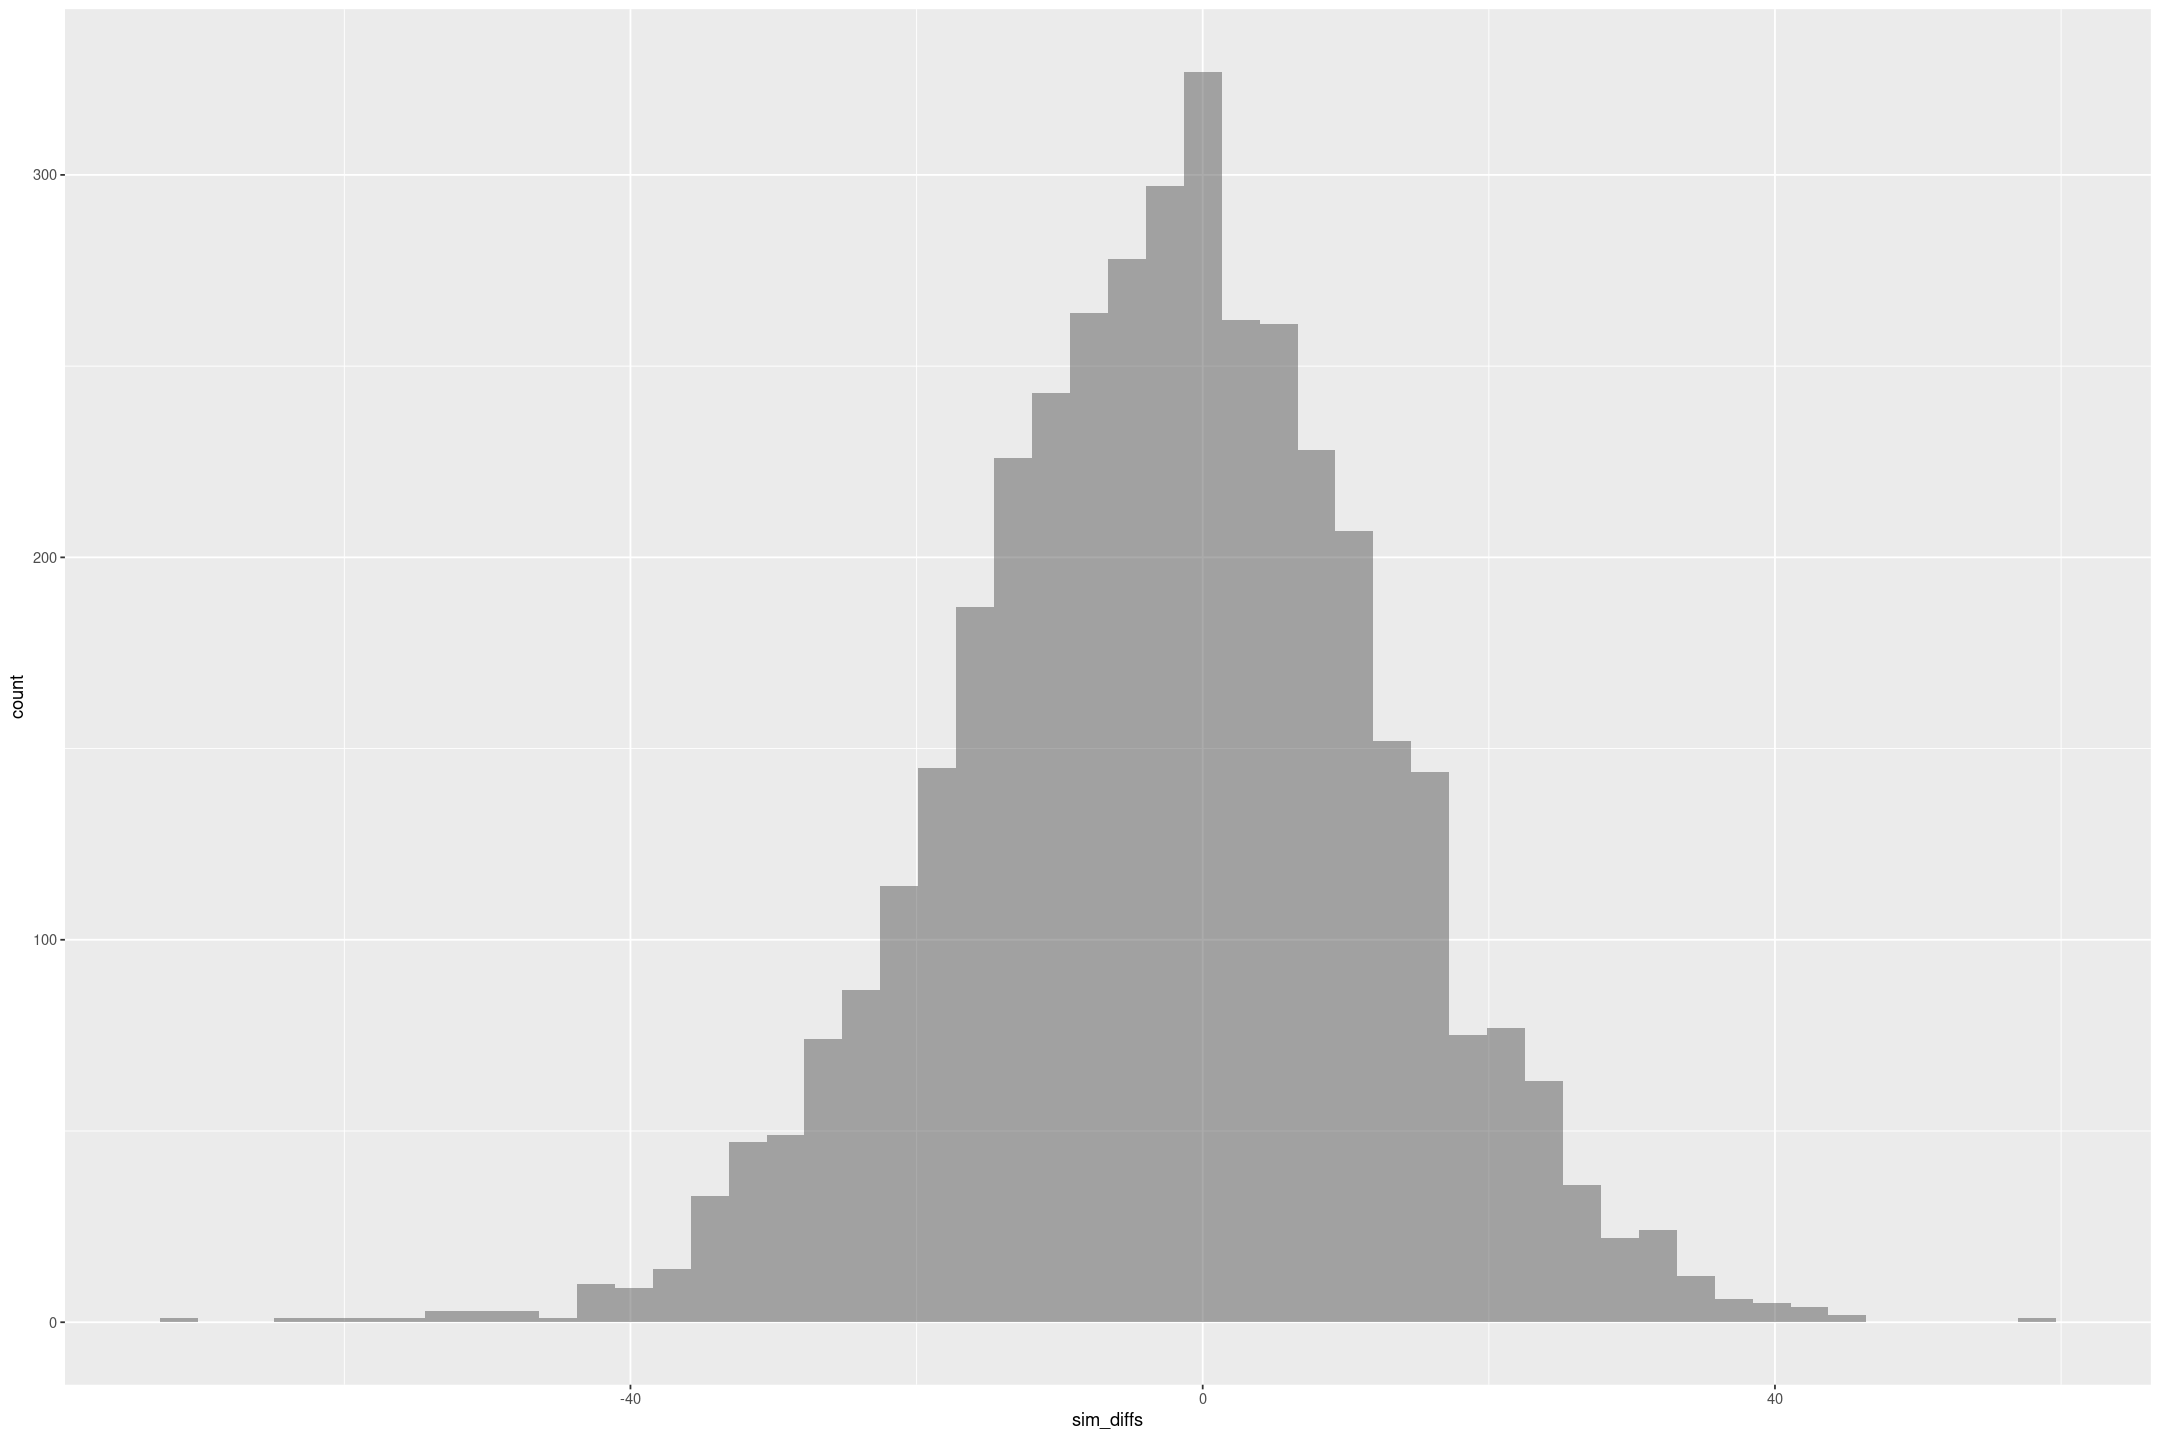

In [9]:
gf_histogram(~sim_diffs, bins=50)

Finally calculate the 90% predictive interval, from the 5th quantile to the 95th quantile

In [10]:
quantile(sim_diffs, c(0.05, 0.95))

5%       95% 
-26.66605  21.56674

Putting it all together

In [11]:
predictive_difference_interval <- function(model, predictors_1, predictors_2, size=0.9) {
    pred_1 <- posterior_predict(model, newdata=predictors_1)
    pred_2 <- posterior_predict(model, newdata=predictors_2)
    
    diffs <- pred_1 - pred_2
    
    quantile_size = (1 - size) / 2
    unname(quantile(diffs, c(quantile_size, 1-quantile_size)))
}

So this is the 90% prediction interval for the difference in GPAs

In [12]:
predictive_difference_interval(fake_high_school_lm, data.frame(income=40), data.frame(income=80))

[1] -25.33775  21.41632

# Predictive simulation for linear regression

Using data of interest to you, fit a linear regression.
Use the output from this model to simulate a predictive distribution for observations with a particular combination of levels of all the predictors in the regression.

## Getting the data

Let's use the same fertility data from exercise 7.4

In [13]:
importance_religion_html <- xml2::read_html("https://en.wikipedia.org/wiki/Importance_of_religion_by_country")

In [14]:
importance_religion_raw <- importance_religion_html %>%
rvest::html_nodes("table") %>% 
.[[2]] %>%
rvest::html_table()

importance_religion_raw %>% head()

,Rank,Country,"Yes, important[1]","No, unimportant[1]"
,<int>,<chr>,<chr>,<chr>
1,1,Estonia,16%,78%
2,2,Sweden,17%,82%
3,3,Denmark,19%,80%
4,4,Czech Republic[a],21%,75%
5,5,Norway[a],22%,78%
6,6,Japan,24%,75%


In [15]:
convert_percent <- function(x)
    as.numeric(str_remove(x, "%$"))/100

In [16]:
importance_religion <- 
importance_religion_raw %>% 
rename_with(~str_remove(tolower(.), ",.*")) %>%
mutate(year=if_else(str_ends(country, '[a]'), 2008L, 2009L),
       country = as.factor(str_remove(country, "\\[a\\]$")),
       iso2c = countrycode::countrycode(country, origin='country.name', destination='iso2c'),
       yes = convert_percent(yes),
       no = convert_percent(no))

importance_religion

rank,country,yes,no,year,iso2c
<int>,<fct>,<dbl>,<dbl>,<int>,<chr>
1,Estonia,0.16,0.78,2008,EE
2,Sweden,0.17,0.82,2009,SE
3,Denmark,0.19,0.80,2009,DK
4,Czech Republic,0.21,0.75,2009,CZ
5,Norway,0.22,0.78,2009,NO
6,Japan,0.24,0.75,2009,JP
7,Hong Kong,0.24,0.74,2009,HK
8,United Kingdom,0.27,0.73,2009,GB
9,Finland,0.28,0.70,2009,FI


In [17]:
fertility <- WDI::WDI(country=importance_religion$iso2c, indicator="SP.DYN.TFRT.IN", start=2008, end=2009) %>%
rename(fertility = "SP.DYN.TFRT.IN")

In [18]:
religion_fertility <- 
importance_religion %>% rename(religion=yes) %>% select(-no) %>%
left_join(fertility %>% select(-country), by=c('iso2c', 'year'))  %>% 
filter(!is.na(fertility))

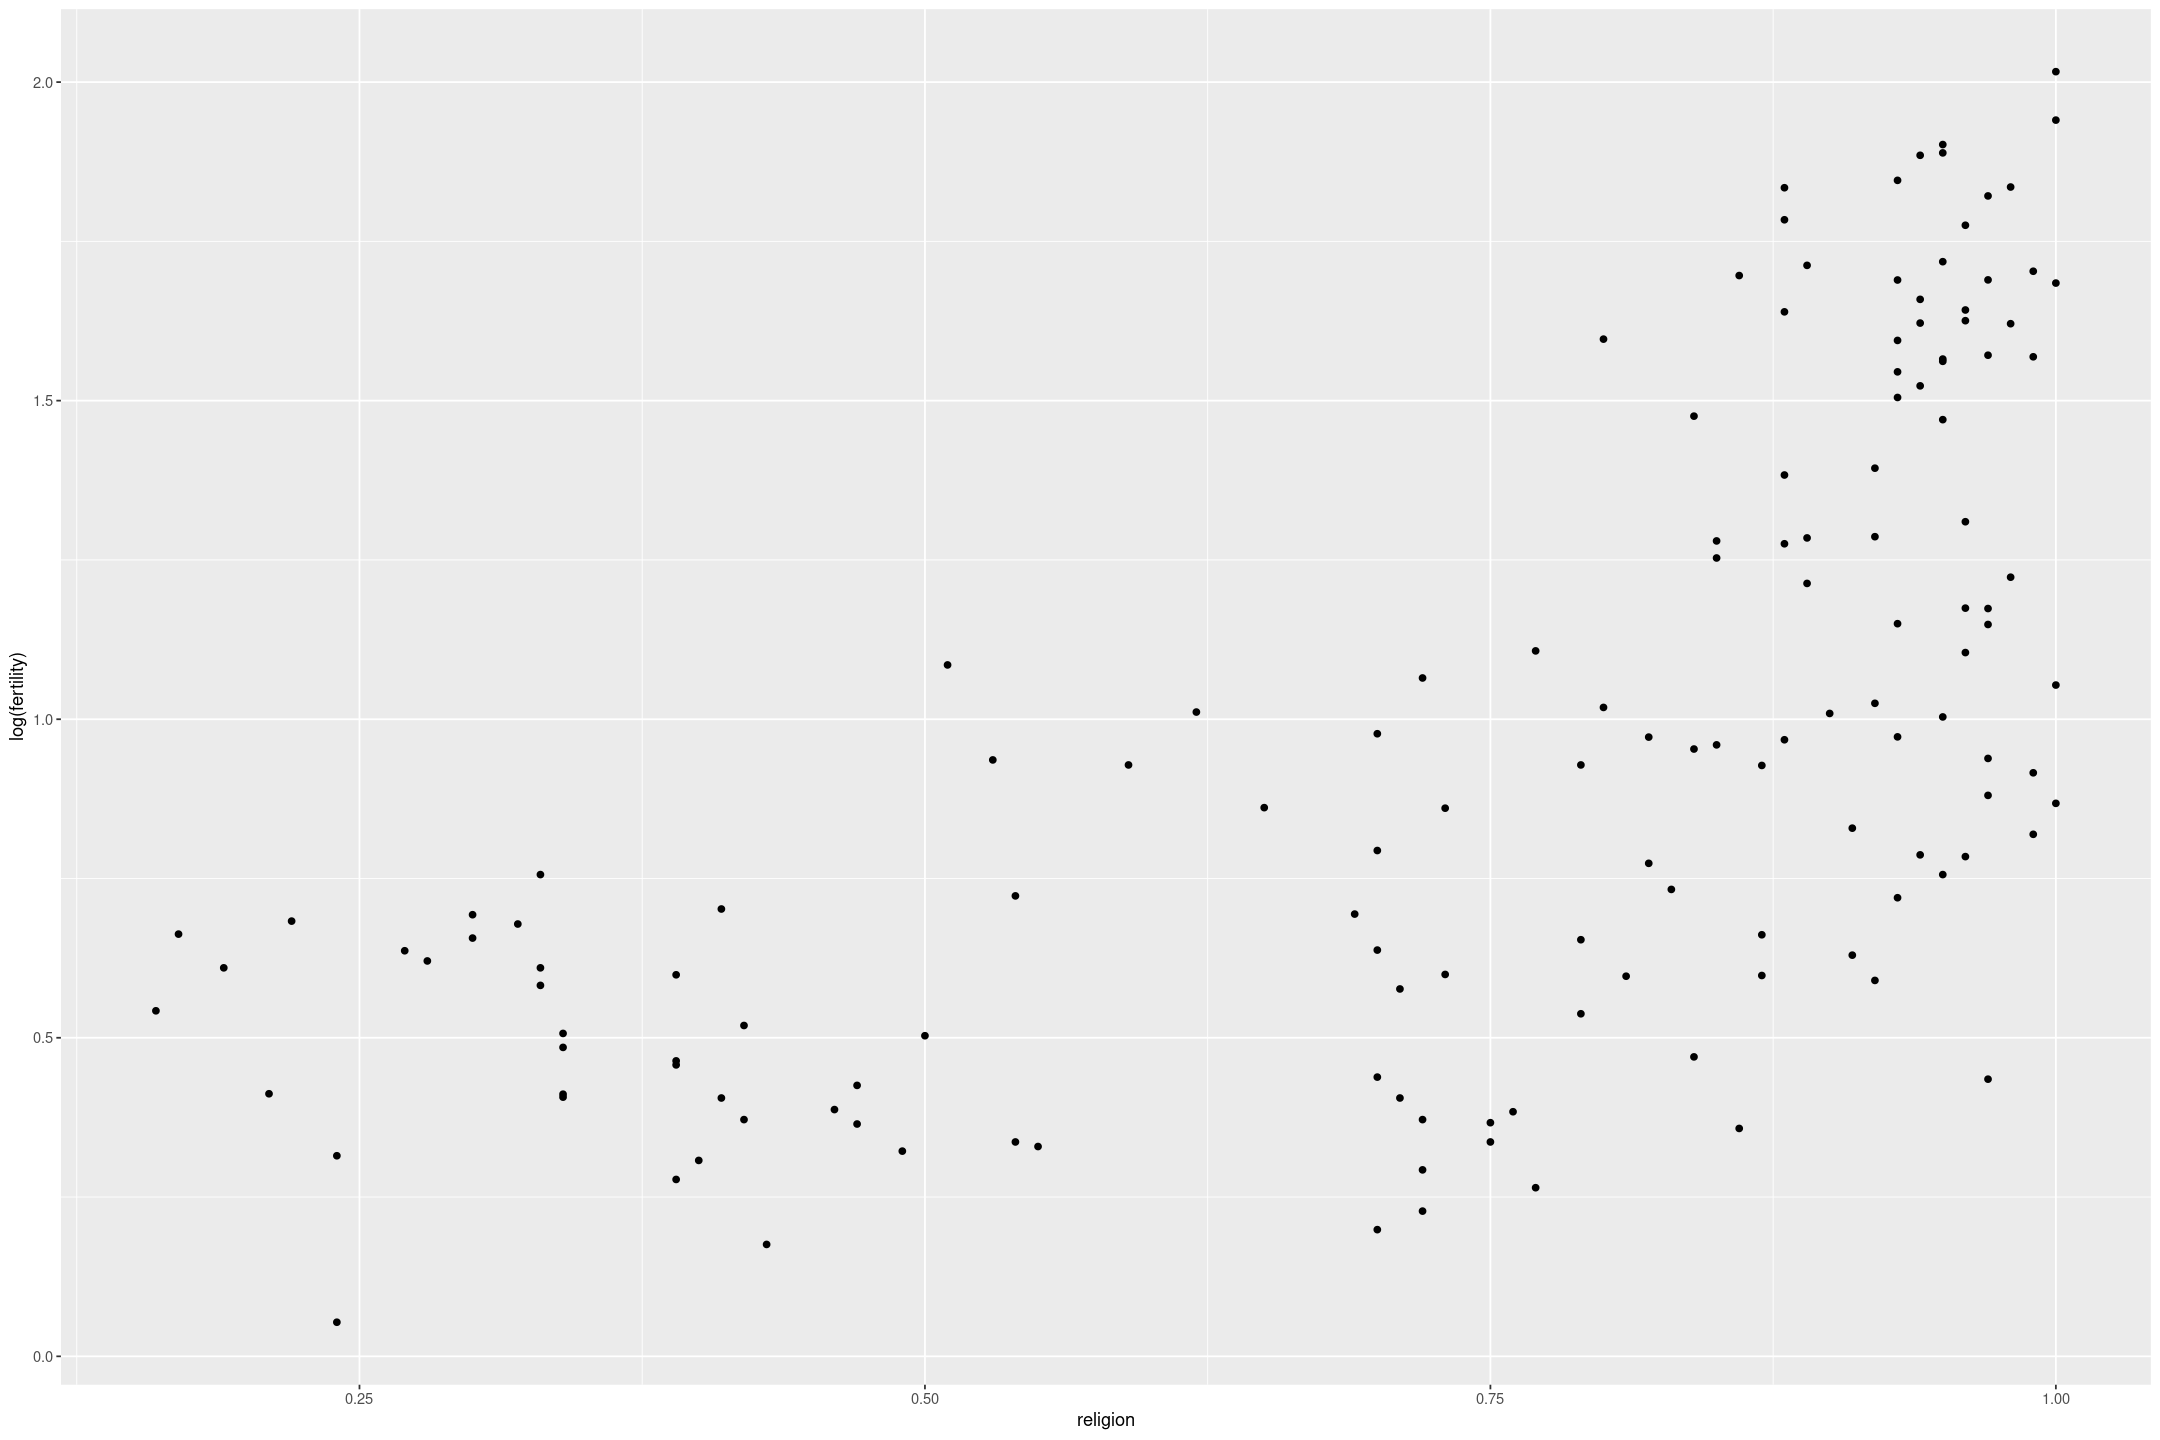

In [19]:
religion_fertility %>% gf_point(log(fertility) ~ religion)

## Fitting a model

In [20]:
religion_fertility_model <- stan_glm(log(fertility) ~ religion, data=religion_fertility, refresh=0)

religion_fertility_model

stan_glm
 family:       gaussian [identity]
 formula:      log(fertility) ~ religion
 observations: 145
 predictors:   2
------
            Median MAD_SD
(Intercept) 0.0    0.1   
religion    1.3    0.1   

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.4    0.0   

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

## Making predictions

Let's look across the percentage of people that say religion is important to their lives, from 0 to 100%.

In [21]:
value_importance_religion <- seq(0, 1, by=0.1)
value_importance_religion

[1] 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In [22]:
prediction_importance_religion <- posterior_predict(religion_fertility_model, newdata=tibble(religion=value_importance_religion))

c(nrow(prediction_importance_religion), ncol(prediction_importance_religion))

[1] 4000   11

In [23]:
df_prediction_importance_religion <- prediction_importance_religion %>% as_tibble %>% mutate_all(as.double)

In [24]:
names(df_prediction_importance_religion) <- as.character(value_importance_religion)

In [25]:
library(tidyr)

In [26]:
df_long_prediction_importance_religion <- 
df_prediction_importance_religion %>% 
pivot_longer(cols=as.character(value_importance_religion), names_to="religion", values_to="logfertility") %>%
mutate(fertility = exp(logfertility))

df_long_prediction_importance_religion

religion,logfertility,fertility
<chr>,<dbl>,<dbl>
0,-0.01968804,0.9805045
0.1,-0.03789176,0.9628172
0.2,0.49418027,1.6391540
0.3,0.13626609,1.1459868
0.4,0.72986777,2.0748062
0.5,0.85149444,2.3431459
0.6,1.05733232,2.8786813
0.7,0.87866795,2.4076904
0.8,0.94934650,2.5840205


## Viewing predictions

Looking at log fertility the data looks normal and shifts to the right.

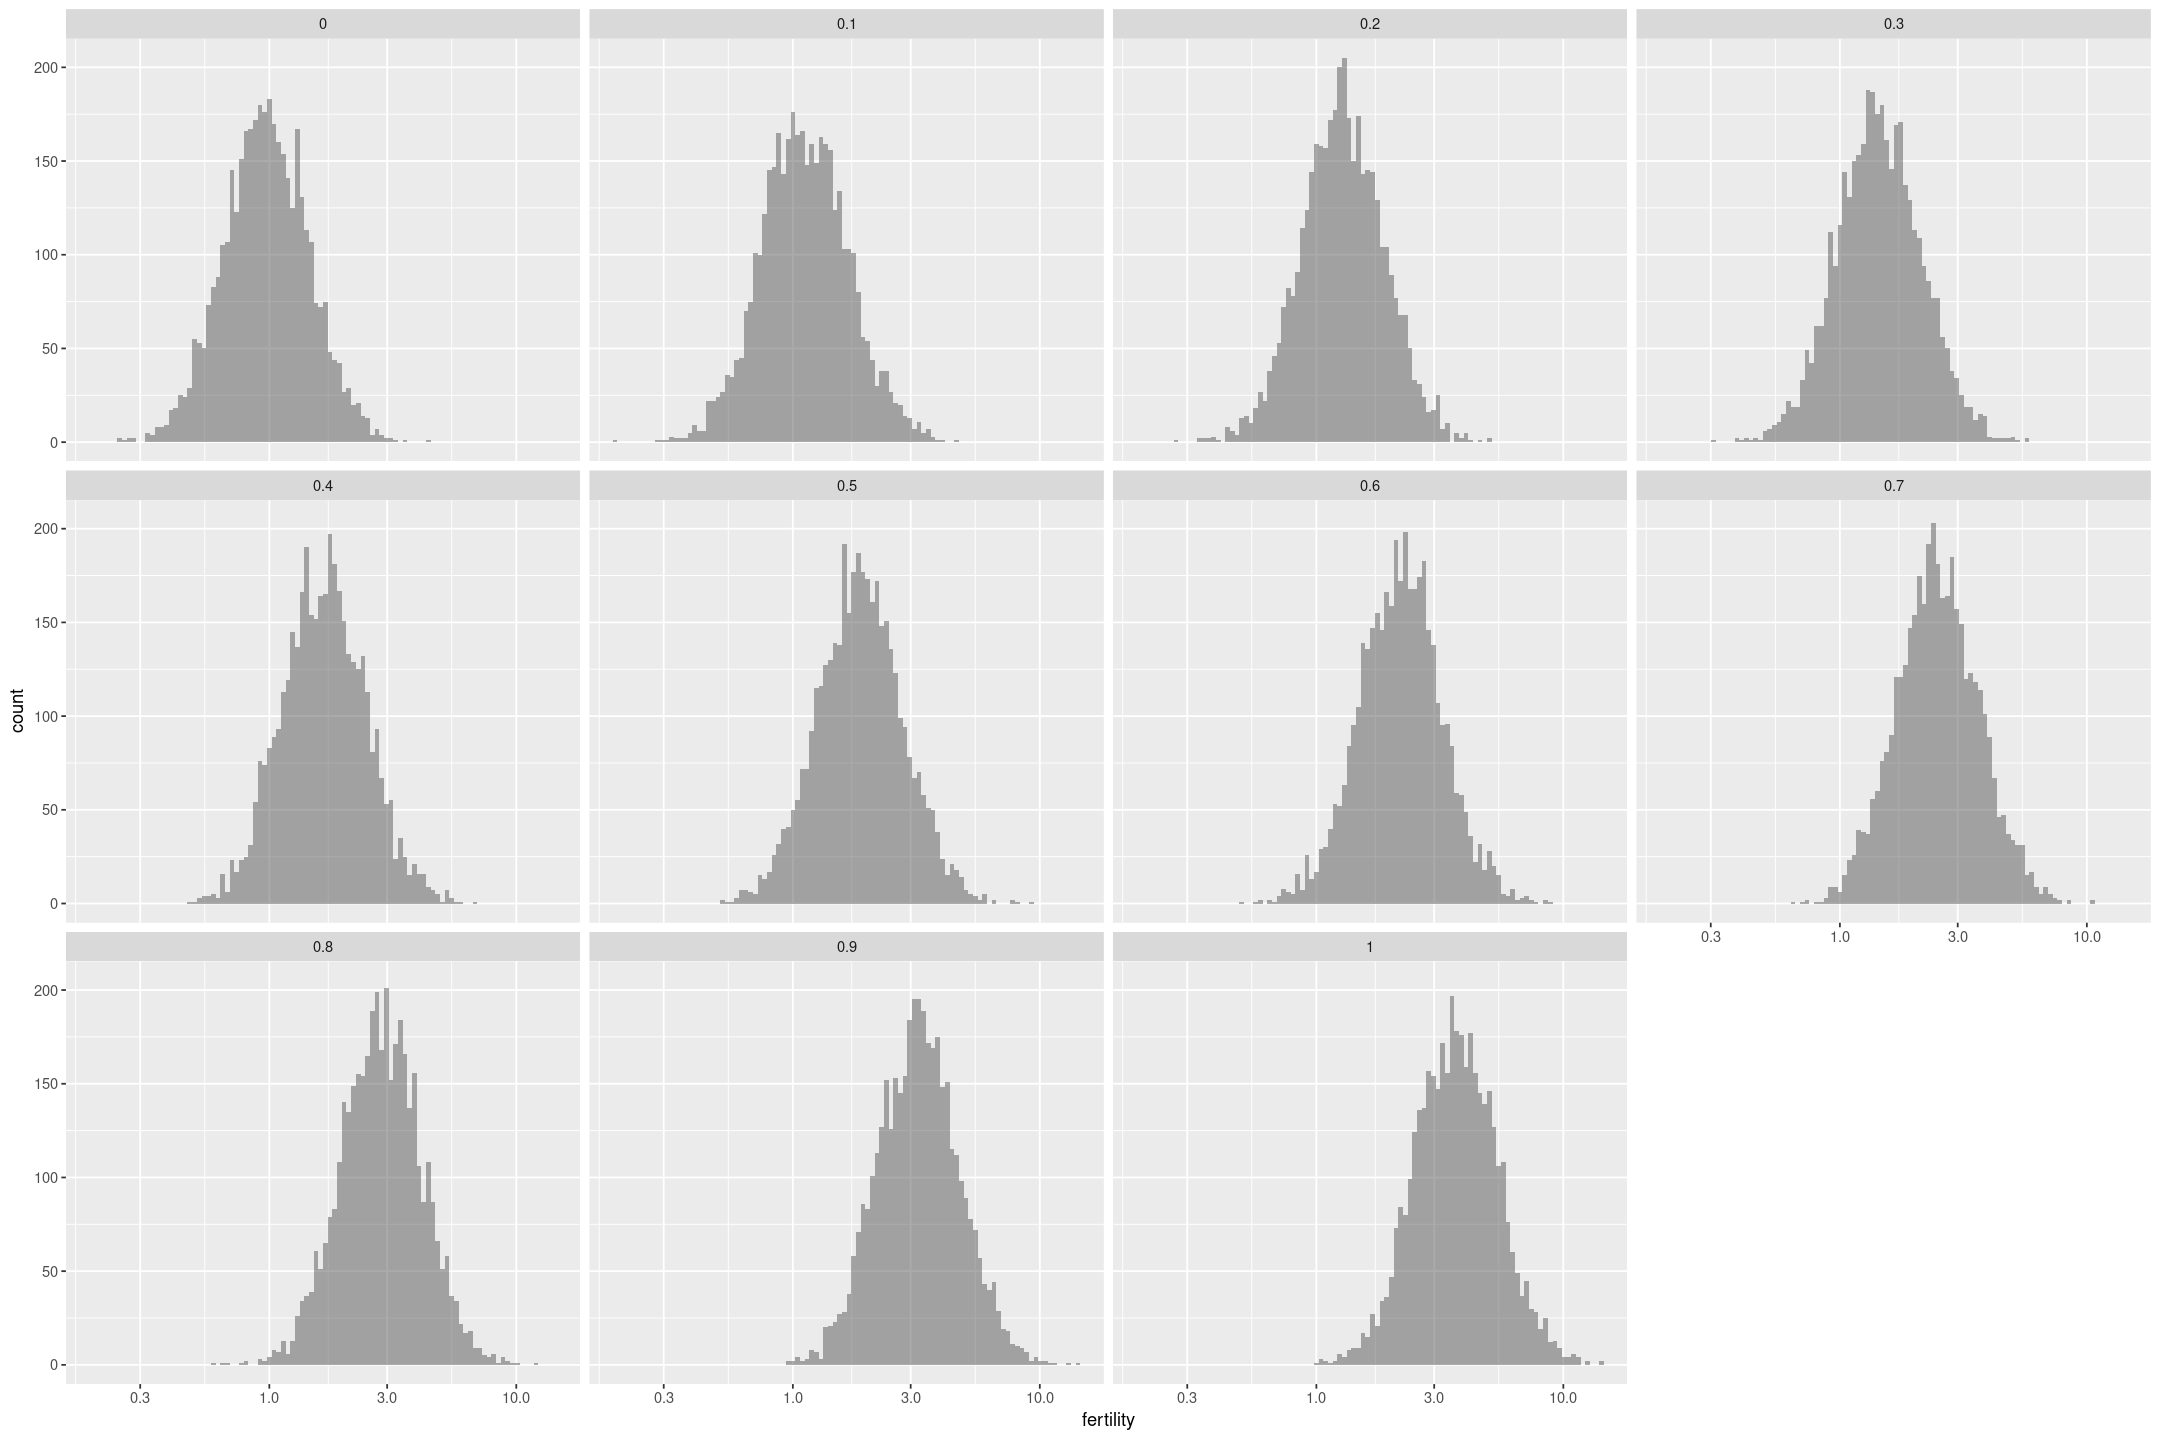

In [27]:
df_long_prediction_importance_religion %>% gf_histogram(~fertility | religion, bins=100) + scale_x_log10()

When we exponetiate this it makes the tails longer with increasing religiosity

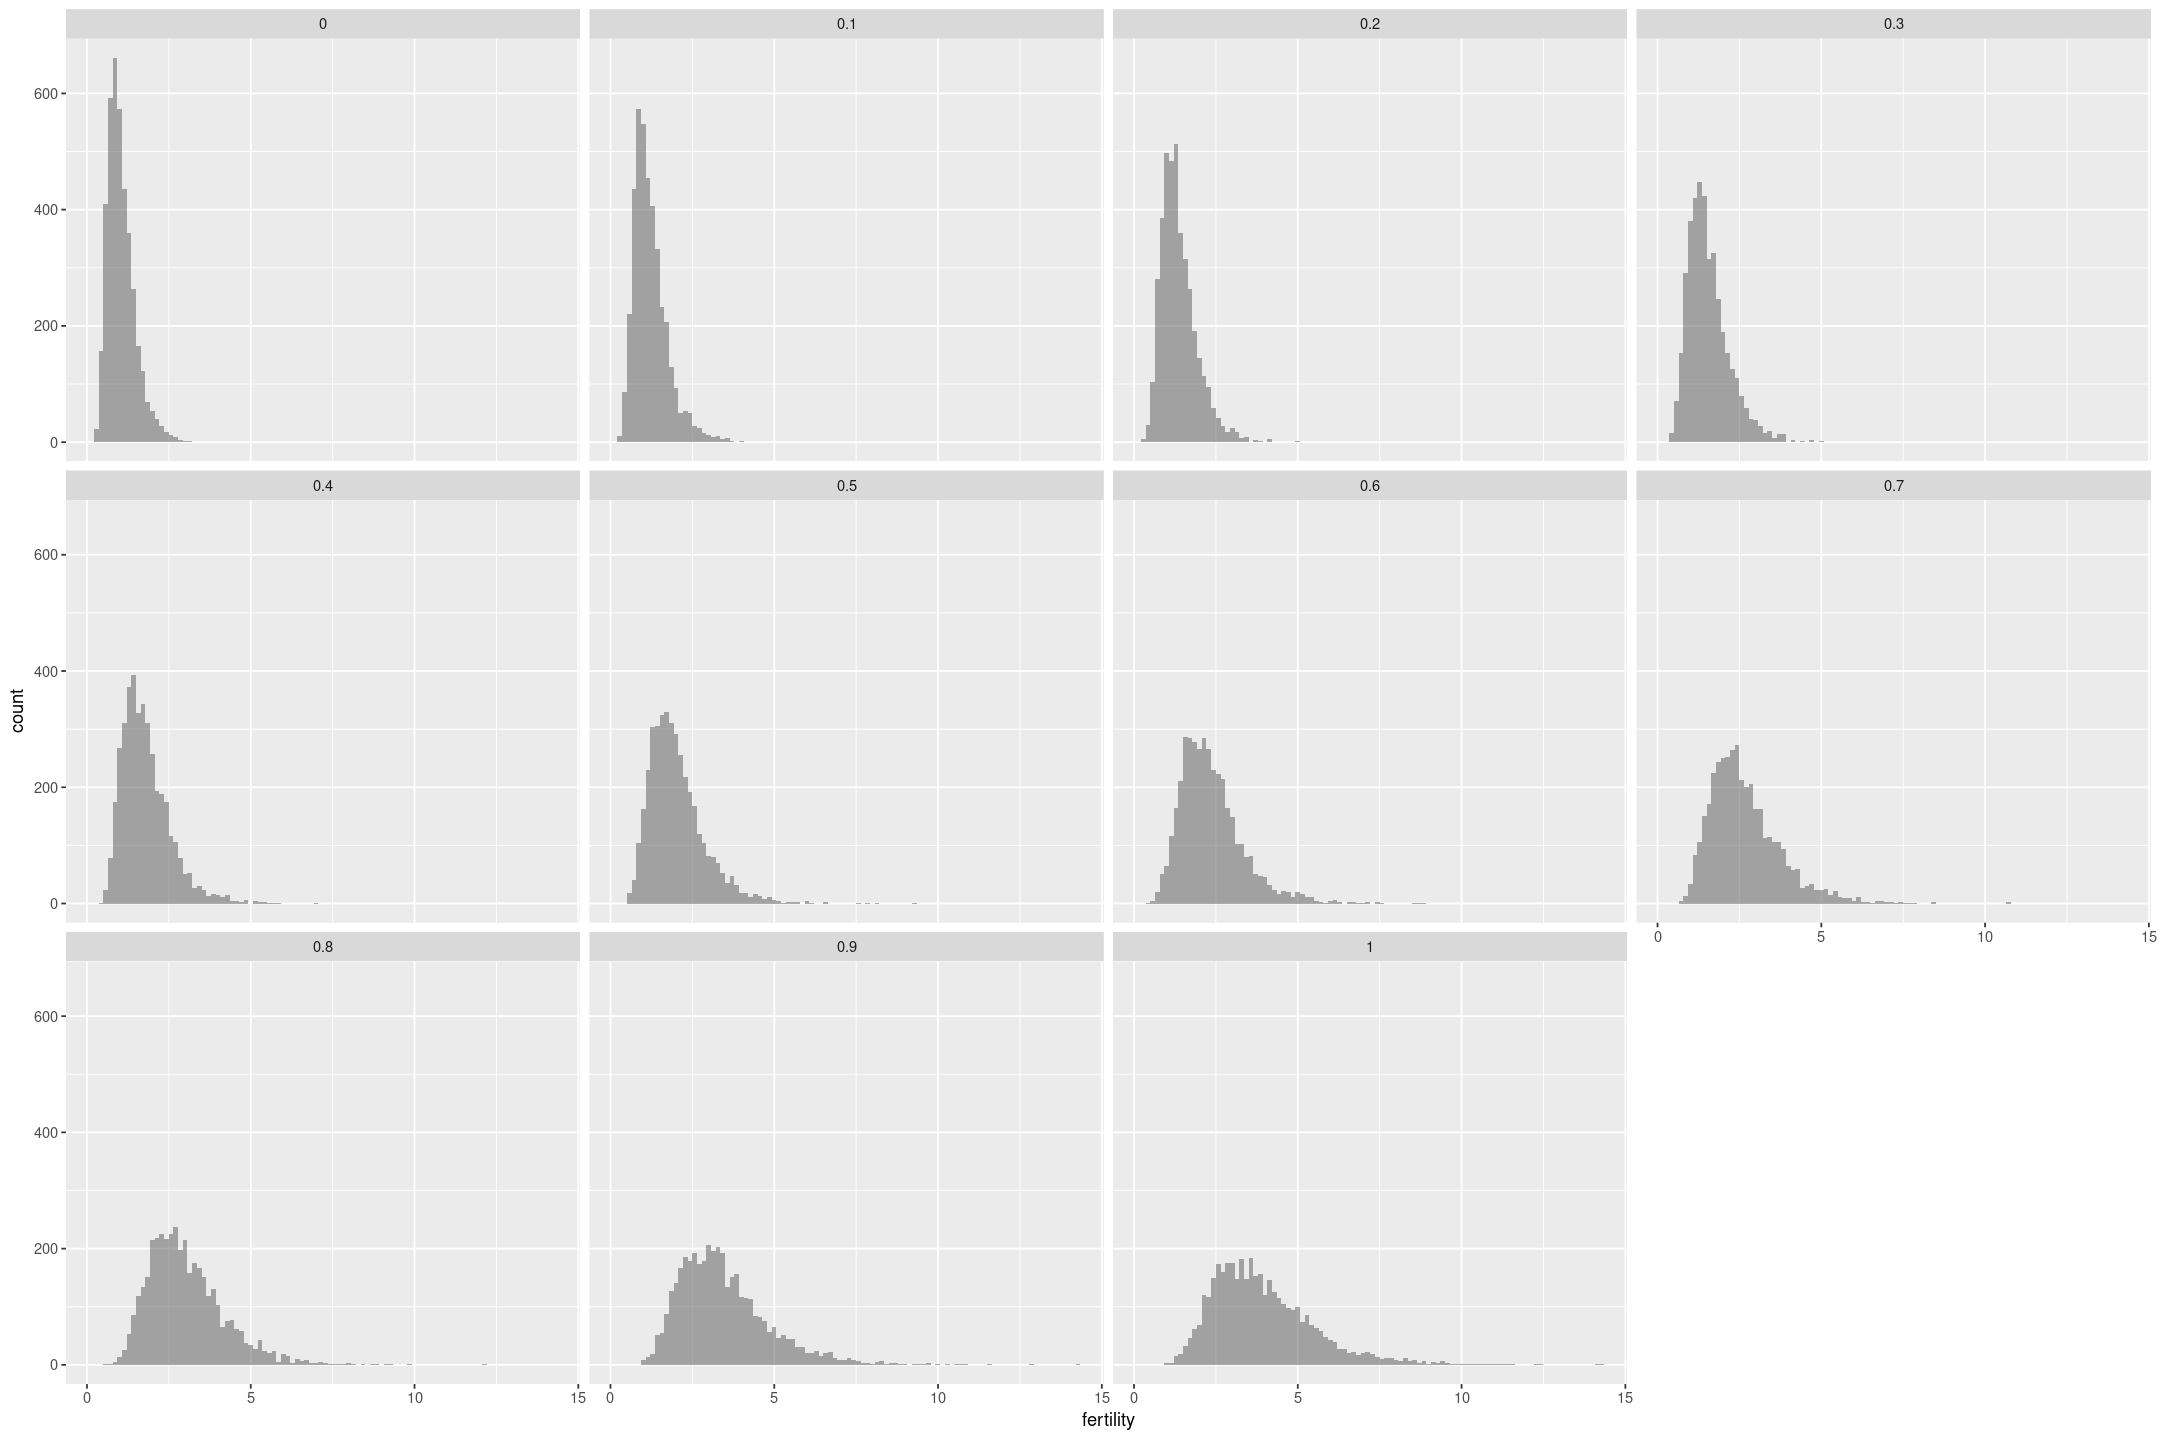

In [28]:
df_long_prediction_importance_religion %>% gf_histogram(~fertility | religion, bins=100)

Another way to look at this is as a violin plot; in log scale.

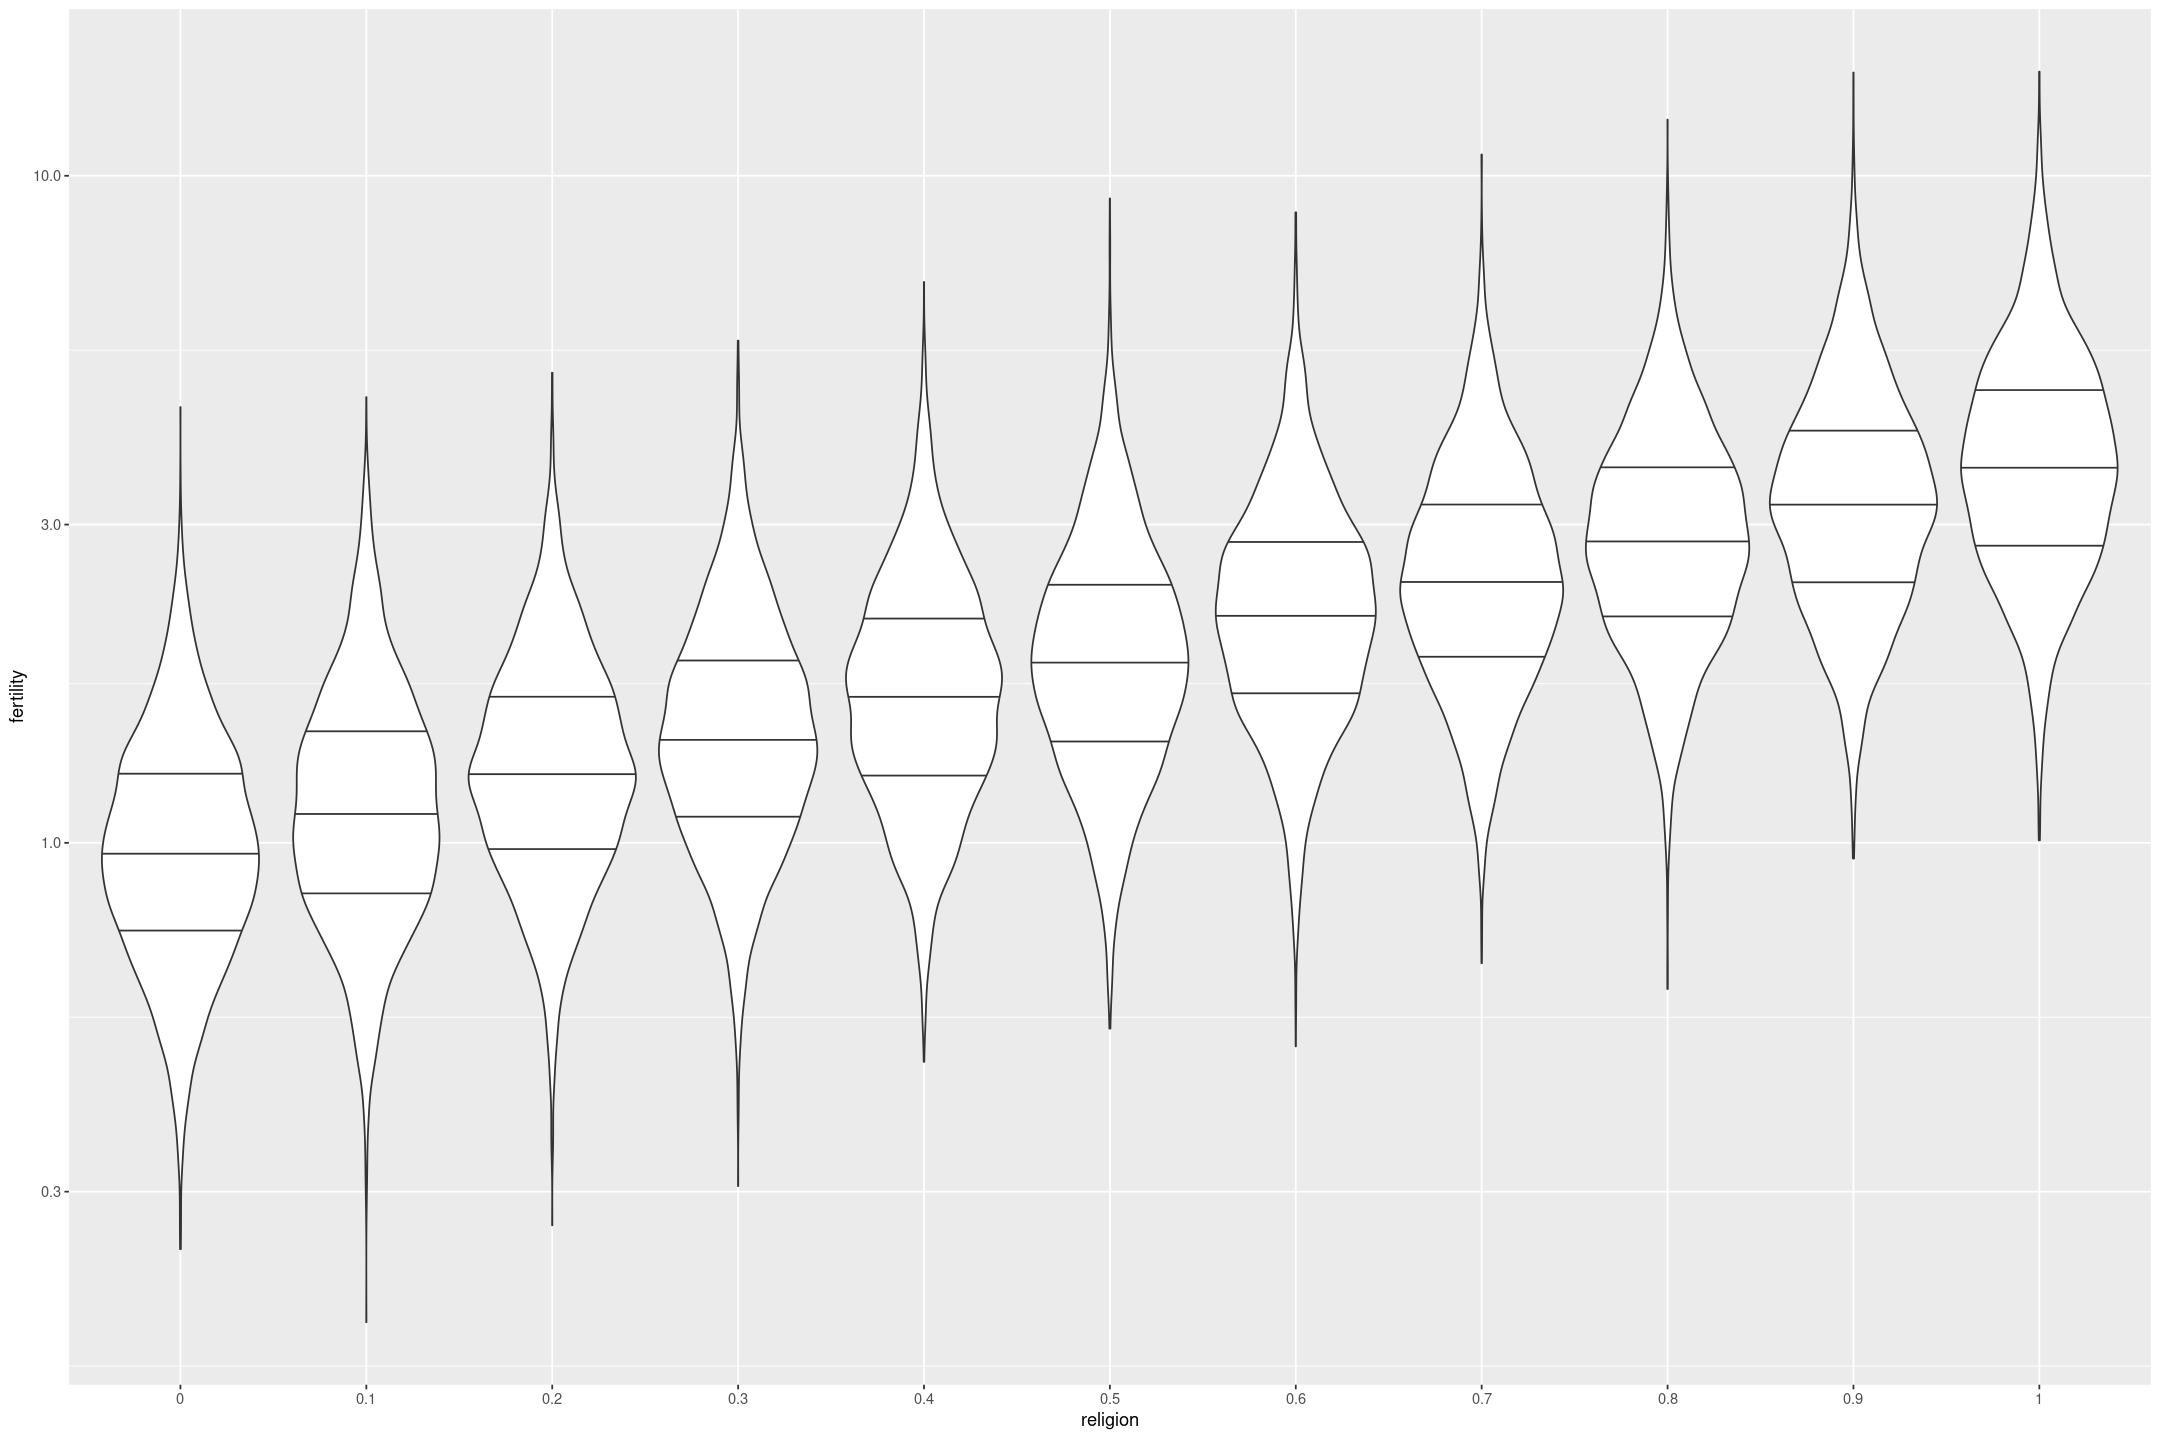

In [29]:
df_long_prediction_importance_religion %>% gf_violin(fertility ~ religion, draw_quantiles=c(0.25, 0.5, .75)) + scale_y_log10()

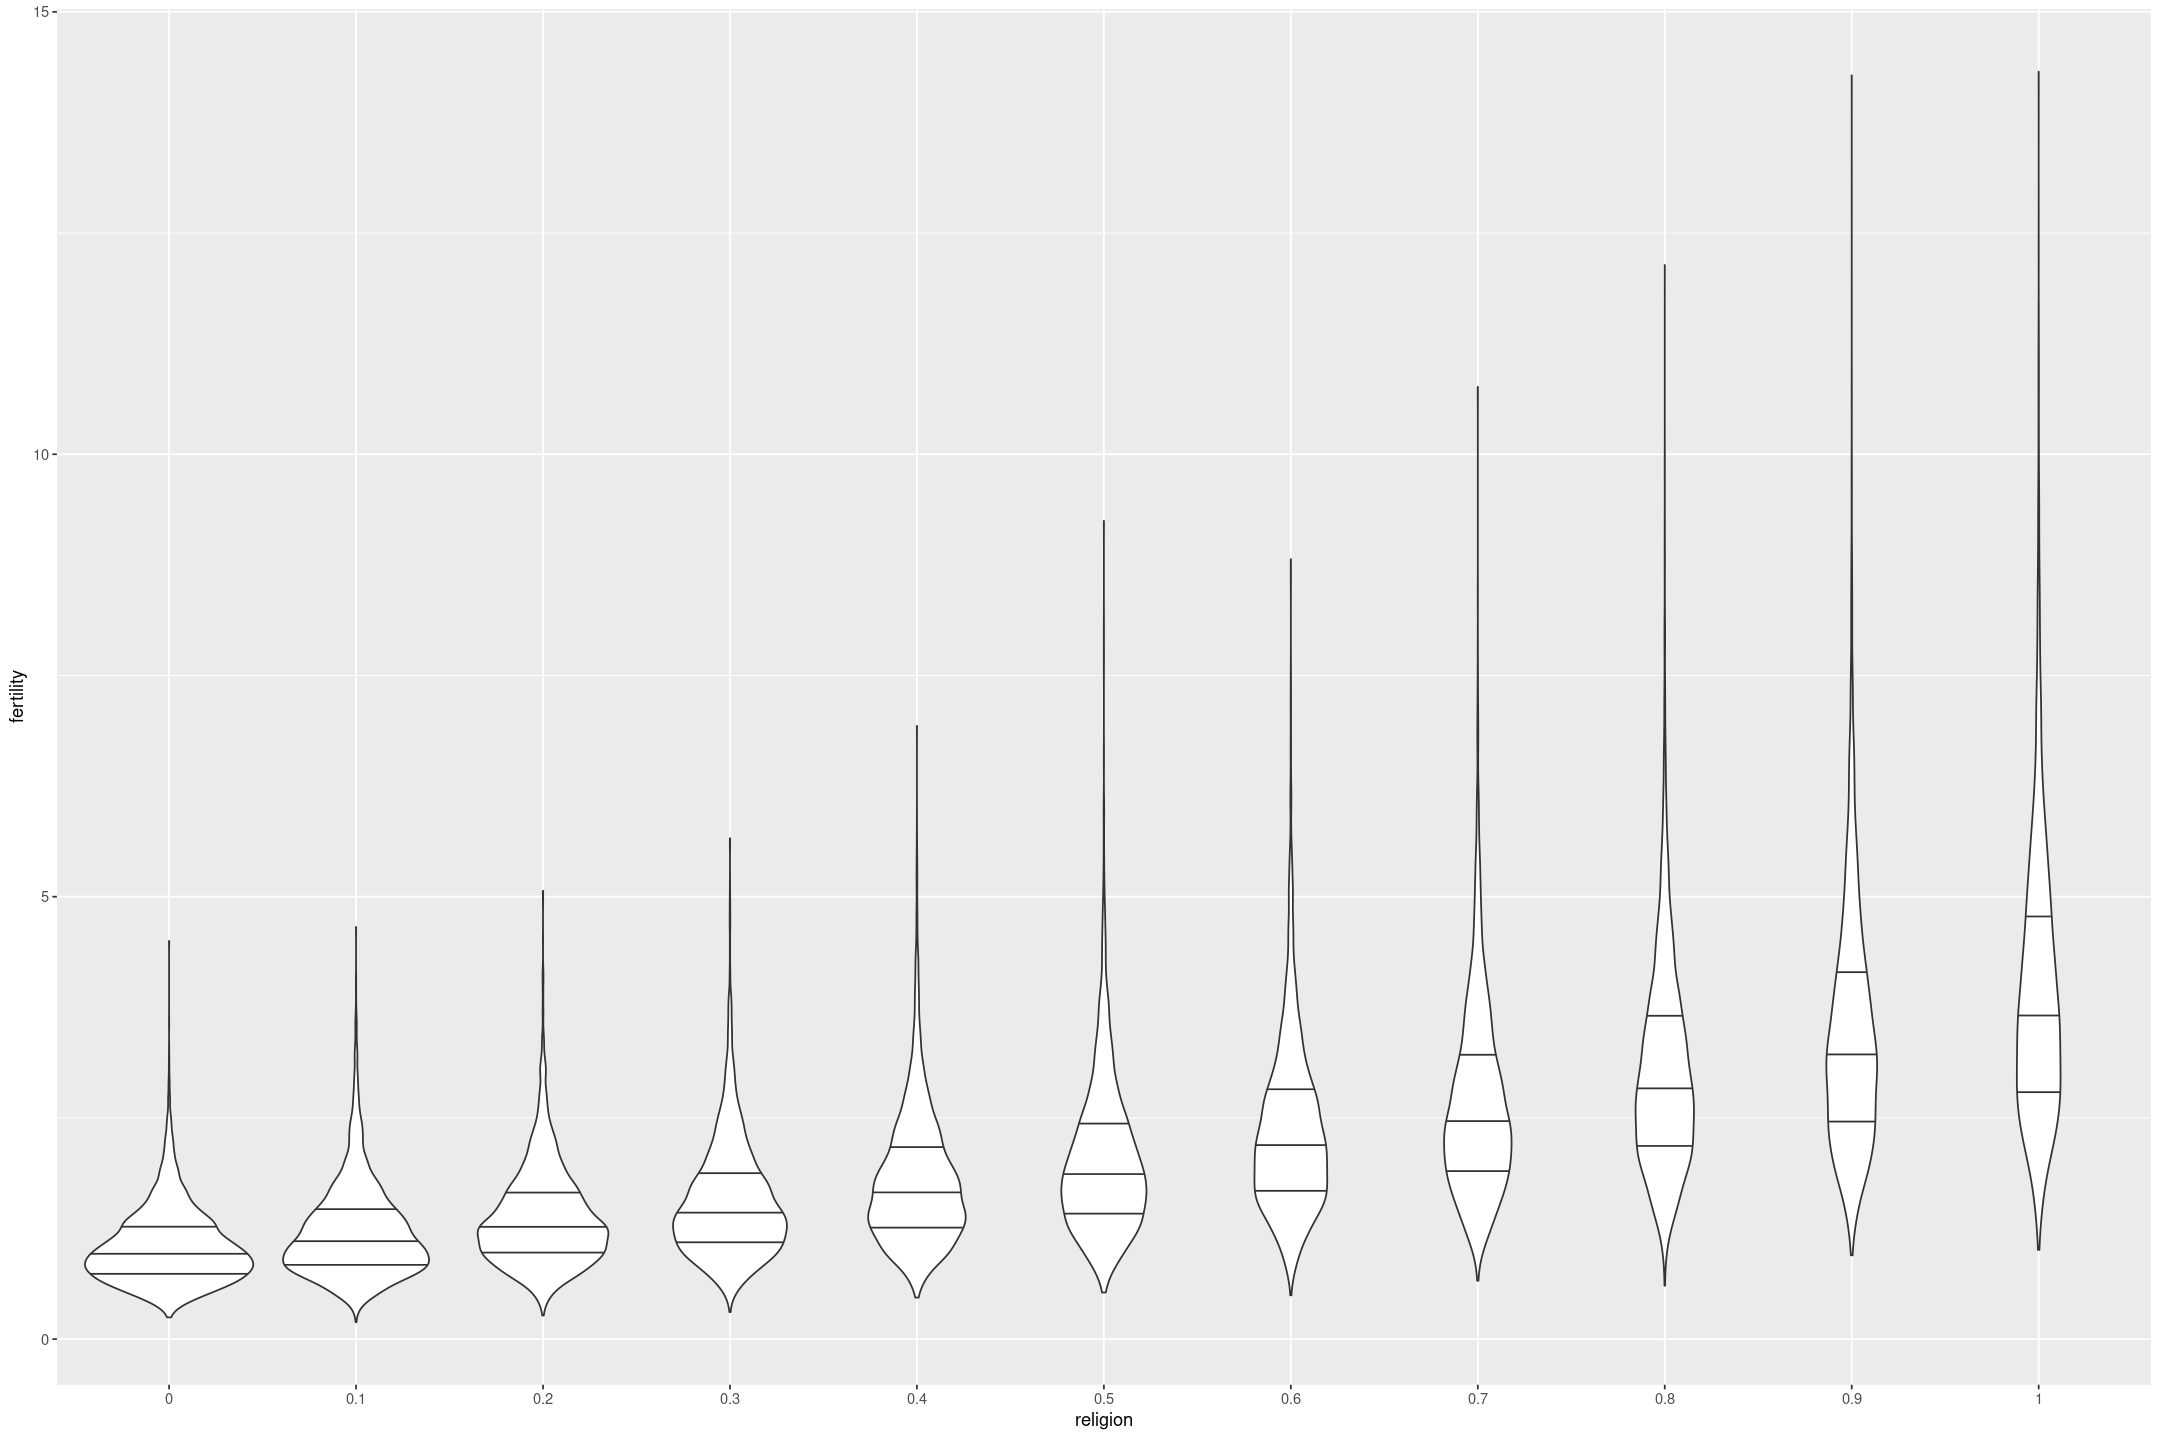

In [30]:
df_long_prediction_importance_religion %>% gf_violin(fertility ~ religion, draw_quantiles=c(0.25, 0.5, .75))

# Uncertainty in the predicted expectation and forecast

Conside the economy and voting example from Section 7.1.
Fit the linear regression model to the data through 2012; these are available in the folder [`ElectionsEconomy`](https://github.com/avehtari/ROS-Examples/tree/master/ElectionsEconomy/). Make a forecast for the incumbent party's share of the two-party vote in a future election where the economic growth is 2%.

In [31]:
filename <- "./data/ElectionsEconomy/hibbs.dat"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/ElectionsEconomy/data/hibbs.dat')
hibbs <- read.table(filename, header=TRUE)

In [32]:
election_model <- stan_glm(vote ~ growth, data=hibbs, refresh=0)

## From Formula
Compute the point forecast, the standard deviation of the predicted expectation from 

$$ \hat{\sigma}_{\rm{linpred}}  = \hat{\sigma} \sqrt{\frac{1}{n} + \frac{\left(x^{\rm{new}} - \bar{x}\right)^2}{\sum_{i=1}^{n} \left(x_i - \bar{x}\right)^2}} $$


and the standard deviation of the predicted value from


$$ \hat{\sigma}_{\rm{precition}}  = \hat{\sigma} \sqrt{1 + \frac{1}{n} + \frac{\left(x^{\rm{new}} - \bar{x}\right)^2}{\sum_{i=1}^{n} \left(x_i - \bar{x}\right)^2}} $$


In [33]:
election_intercept <- coef(election_model)[[1]]
election_growth <- coef(election_model)[[2]]
election_sigma <- sigma(election_model)
election_n <- nrow(hibbs)
c(election_intercept, election_growth, election_sigma, election_n)

[1] 46.244234  3.047870  3.894177 16.000000

In [34]:
hibbs_growth_mean <- mean(hibbs$growth)
hibbs_growth_sd <- sd(hibbs$growth)

hibbs_growth_mean
hibbs_growth_sd

[1] 1.8975

[1] 1.395538

The point forecast is straightforward

In [35]:
election_intercept + election_growth * 2.0

[1] 52.33997

The standard deviation in the predicted expectation

In [36]:
election_sigma * sqrt(1/election_n + (2.0 - hibbs_growth_mean)^2 / hibbs_growth_sd^2)

[1] 1.01469

The standard deviation in the predicted value

In [37]:
election_sigma * sqrt(1 + 1/election_n + (2.0 - hibbs_growth_mean)^2 / hibbs_growth_sd^2)

[1] 4.024203

## From prediction functions
Now compute thse using the relevant prediction functions discussed in Section 9.2. Check that you get the same values.

### Point Estimate

The point estimate is very close

In [38]:
predict(election_model, newdata=data.frame(growth=2.0))

1 
52.35606

### Standar Deviation in predicted expectation

The standard devation is close

In [39]:
sd(posterior_linpred(election_model, newdata=data.frame(growth=2.0)))

[1] 1.026096

### Standard Deviation in predicted expectation

The standard devation of prediction is close; a little bit larger

In [40]:
sd(posterior_predict(election_model, newdata=data.frame(growth=2.0)))

[1] 4.164835

### Exploring the posterior predictions

In [41]:
twoparty_predictions <- as.double(posterior_predict(election_model, newdata=data.frame(growth=2.0)))

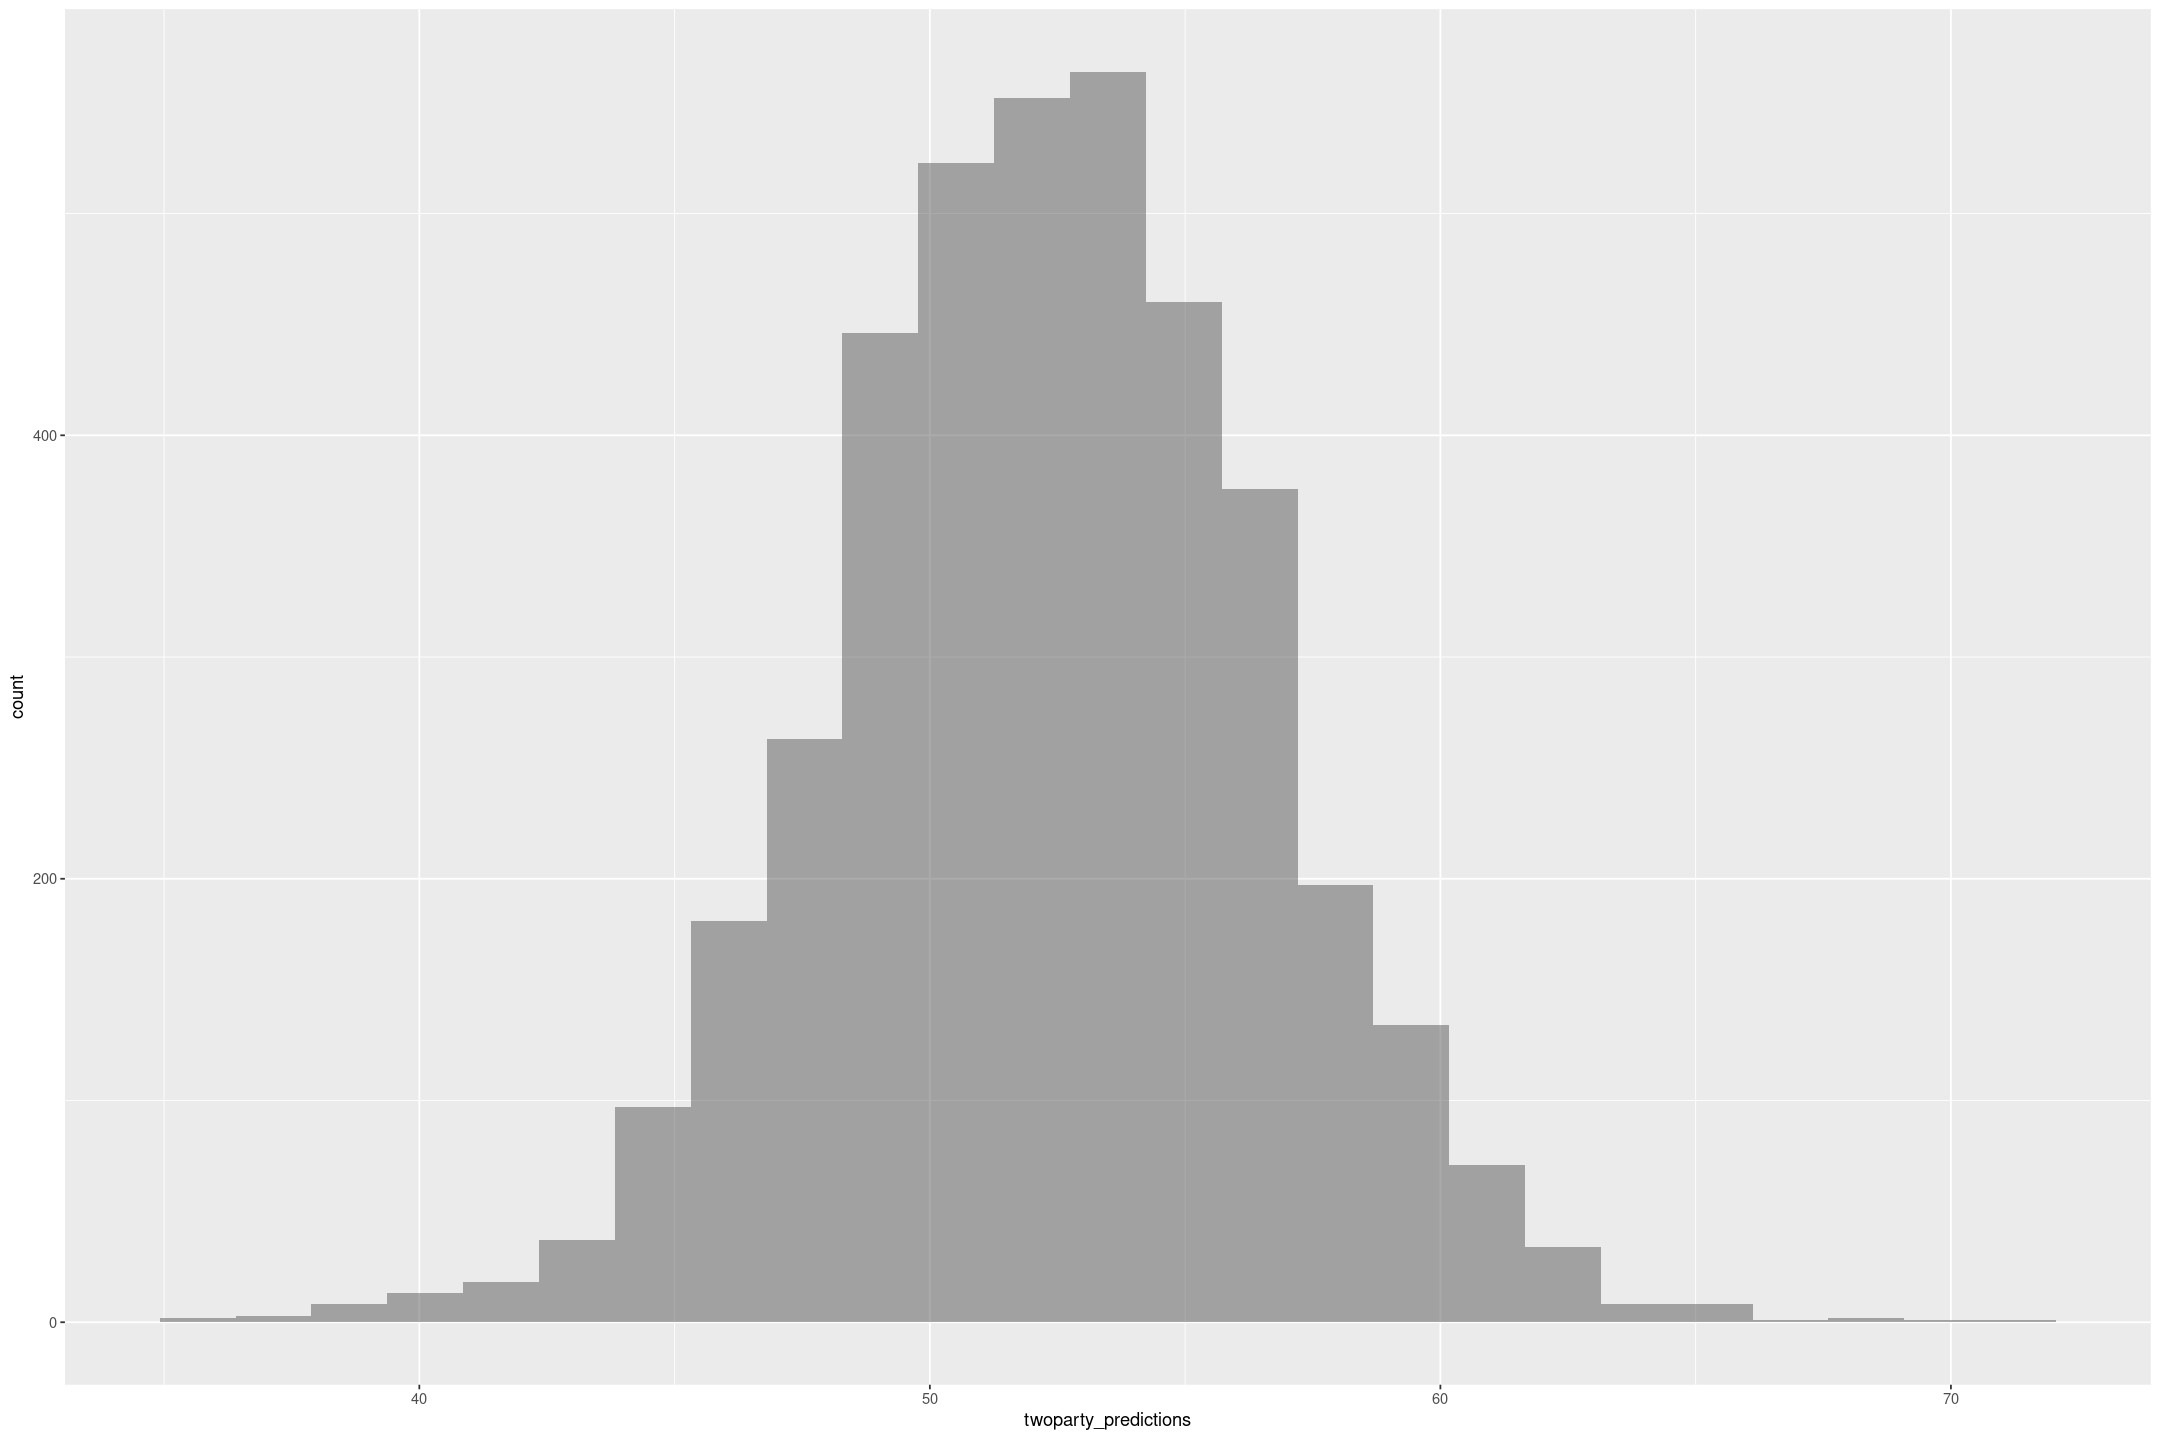

In [42]:
gf_histogram(~twoparty_predictions)

Point forecast of 52%

In [43]:
median(twoparty_predictions)

[1] 52.38225

The mean average deviation of the prediction is 4 percentage points.

In [44]:
mad(twoparty_predictions)

[1] 4.111742

Probability of a win for the incumbent is 72%

In [45]:
mean(twoparty_predictions > 50)

[1] 0.7135

# Partial Pooling

Conside the example in Section 9.3 of combining prior information and survey data to forecast an election.
Suppose your prior forecast for a given candidate's share of the two-party vote is 42% with a forecast standard deviation of 5 percentage points, and you have survey data in which this candidate has 54% support.
Assume the survey is a simple random sample of voters with no nonresponse, and that voters will not change their mind between the time of the survey and the election.

The posterior mean, assuming a normal distribution (which a binomial distribution like this can be approximated by), is a weighted mean of the prior and the data weighted by inverse squared error:

$$ \hat{\theta}_{\rm{Bayes}} = \left.\left(\frac{\hat{\theta}_{\rm{prior}}}{\rm{se}^2_{\rm{prior}}} + \frac{\hat{\theta}_{\rm{data}}}{\rm{se}^2_{\rm{data}}}\right) \middle/ \left(\frac{1}{\rm{se}^2_{\rm{prior}}} + \frac{1}{\rm{se}^2_{\rm{data}}}\right) \right. $$

## Sample Size
When you do the calculation, it turns out that your posterior mean estimate of the candidate's vote share is 49%. What must the sample size of the survey be?

Rearranging the above equation and solving for the standard error of the data gives

$$ \rm{se}_\rm{data} = \rm{se}_\rm{prior} \sqrt{\frac{ \hat{\theta}_{\rm{Bayes}} - \hat{\theta}_{\rm{data}} }{ \hat{\theta}_{\rm{prior}} - \hat{\theta}_{\rm{Bayes}} }} $$

The standard error in the data needs to be about 4 percentage points

In [46]:
se_prior <- .05
theta_prior <- .42
theta_data <- .54
theta_bayes <- .49

se_data <- se_prior * sqrt((theta_bayes - theta_data) / (theta_prior - theta_bayes))
se_data

[1] 0.04225771

Check this corresponds to a posterior estimate of 49%

In [47]:
(theta_prior / se_prior^2 + theta_data/se_data^2) / (1/se_prior^2 + 1/se_data^2)

[1] 0.49

Under the assumptions of a random sample with no non-response, and time invariance, we can model this by a simple binomial distribution.
Then the standard error is given by

$$ \rm{se}_\rm{data} = \sqrt{\frac{p(1-p)}{n}} $$

It's not immediately obvious to me whether p should be the estimate in the data, or the posterior estimate.
The posterior estimate is likely closer to the actualy value so I guess we should use that.
In any case they're both pretty close to 50%, so we'll just use that.

$$ n = \frac{p(1-p)}{\rm{se}_{\rm{data}}^2} \approx \frac{1}{4 \rm{se}_{\rm{data}}^2} $$

The sample size must be 140

In [48]:
p <- 0.5
p * (1-p) / (se_data^2)

[1] 140

Note using either estimate gives the same result

In [49]:
p <- theta_data
p * (1-p) / (se_data^2)

[1] 139.104

In [50]:
p <- theta_bayes
p * (1-p) / (se_data^2)

[1] 139.944

## Calculating posterior

Given this information, what is the posterior probability that the candidate wins the election?

First we need to calculate our posterior standard error

$$ \rm{se}_{Bayes} = \left. 1 \middle/ \sqrt{ \frac{1}{\rm{se}^2_{\rm{prior}}} + \frac{1}{\rm{se}^2_{\rm{data}}} } \right.$$

In [51]:
c(se_prior, se_data)

[1] 0.05000000 0.04225771

Our estimated error is about 3 percentage points

In [52]:
se_bayes <- 1 / sqrt(1 / se_prior^2 + 1/ se_data^2)
se_bayes

[1] 0.03227486

To calculate the posterior probability that the candidate wins the election, we need to know the probability the posterior normal distribution is greater than 0.5.

This is 1 - the cumulative probability that it's less than 0.5.

This works out to 38%.

In [53]:
1 - pnorm(0.5, mean = theta_bayes, sd = se_bayes)

[1] 0.3783418

# Combining prior information and data

A new job training program is being tested. Based on the success and failures of previously proposed innovations, your prior distribution on the effect size on log(income) is normal with a mean of -0.02 and a standard deviation of 0.05. You then conduct an experiment which gives an unbiased estimate of the treatment effect of 0.16 with a standard deviation of 0.08. What is the posterior mean and standard deviation of the treatment effect?

As in the last question we use the formulae for posteriors for combining a normally distributed prior with normally distributed model, to get a normally distributed posterior:

$$ \hat{\theta}_{\rm{Bayes}} = \left.\left(\frac{\hat{\theta}_{\rm{prior}}}{\rm{se}^2_{\rm{prior}}} + \frac{\hat{\theta}_{\rm{data}}}{\rm{se}^2_{\rm{data}}}\right) \middle/ \left(\frac{1}{\rm{se}^2_{\rm{prior}}} + \frac{1}{\rm{se}^2_{\rm{data}}}\right) \right. $$

$$ \rm{se}_{Bayes} = \left. 1 \middle/ \sqrt{ \frac{1}{\rm{se}^2_{\rm{prior}}} + \frac{1}{\rm{se}^2_{\rm{data}}} } \right.$$

Prior model: log(income) ~ N(-0.02, 0.05)

Data: log(income) ~ N(0.16, 0.08)

In [54]:
prior_mean <- -0.02
prior_se <- 0.05

data_mean <- 0.16
data_se <- 0.08

In [55]:
posterior_mean <- (prior_mean / prior_se^2 + data_mean / data_se^2) / (1/prior_se^2 + 1 / data_se^2)
posterior_mean

[1] 0.0305618

In [56]:
posterior_se <- 1 / (1/prior_se^2 + 1 / data_se^2)
posterior_se

[1] 0.001797753

# Bayesian inference with a zero-centered informative prior on the log scale

Perform the Bayesian analysis for the Jamaica experiment described on page 15.
We shall work on the logarithmic scale.

## Multiplicative treatment Effect

Do Exercise 4.8 to get the estimate and standard error of the log of the multiplicative treatment effect.

The sample size is 127 children, and the increased earnings by 42% with 95% confidence interval, $[+2\%, +98\%]$.

The confidence interval is assuming a logarithmic model, since the point estimate is the geometric mean

In [57]:
sqrt(1.02 * 1.98) / 1.42

[1] 1.000793

The point estimate is the centre of the range in log scale; or equivalently the log of the centre point.

In [58]:
jamaica_log_l95 <- log(1.02)
jamaica_log_u95 <- log(1.98)

jamaica_log_point <- (jamaica_log_l95 + jamaica_log_u95) / 2

jamaica_log_point / log(1.42)

[1] 1.002261

To calculate the standard error note that it's 2 standard deviations either side of the point estimate.

So upper - lower = 4 * standard error

In [59]:
jamaica_log_se <- (jamaica_log_u95 - jamaica_log_l95) / 4

jamaica_log_se

[1] 0.1658236

As a check we should recover our original 95% confidence interval

In [60]:
exp(c(jamaica_log_point - 2 * jamaica_log_se, jamaica_log_point + 2 * jamaica_log_se))

[1] 1.02 1.98

## Effect of a prior

Combine these with a normal prior distribution with mean 0 and standard deviation 0.10 to get the posterior distribution of the log of the multiplicative treatment effect.

In [61]:
prior_mean <- 0
prior_se <- 0.1

posterior_log_se <- 1 / sqrt(1 / jamaica_log_se^2 + 1 / prior_se^2)
posterior_log_mean <- (jamaica_log_point / jamaica_log_se^2 + prior_mean / prior_se^2) / (1 / jamaica_log_se^2 + 1 / prior_se^2)

In [62]:
posterior_log_mean

[1] 0.0937263

In [63]:
posterior_log_se

[1] 0.08563383

## Multiplicative scale

Exponentiate the mean of this distribution and check that it comes to 1.09, that is, an estimated treatment effect of +9%.

I'm getting 1.098, which is closer to 1.10.

Still close at 10%

In [64]:
exp(posterior_log_mean)

[1] 1.098259

## Compatibility Interval

Compute the 95% interval on the log scale and exponentiate it; check that this comes to $[0.92, 1.28]$, that is, a range from -8% to +28% on the original scale.

In [65]:
c(exp(posterior_log_mean - 2*posterior_log_se), exp(posterior_log_mean + 2*posterior_log_se))

[1] 0.9253888 1.3034231

I'm getting a range of `[0.93, 1.30]`.

So we get a range of -7% to +30% on the original scale.

It's pretty close; I'm not sure what's happenening with the last 1-2 percentage points, but the point is still clear - with the prior the effect is very small.

# Uniform, weakly informative, and informative priors

Follow the steps of Section 9.5 for a different example, a regression of earnings on height using the data from the folder [`Earnings`](https://github.com/avehtari/ROS-Examples/tree/master/Earnings/). You will need to think what could be an informative prior distribution in this setting.

In [66]:
filename <- "./data/Earnings/earnings.csv"

download_if_missing(filename,
                    'https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv')
earnings <- read.csv(filename)

## Uniform prior distribution

In [67]:
earnings_model_uniform <- stan_glm(earn ~ height, data=earnings, refresh=0,
                                  prior_intercept=NULL, prior=NULL, prior_aux=NULL)

In [68]:
earnings_model_uniform

stan_glm
 family:       gaussian [identity]
 formula:      earn ~ height
 observations: 1816
 predictors:   2
------
            Median   MAD_SD  
(Intercept) -85001.1   8858.6
height        1595.5    133.3

Auxiliary parameter(s):
      Median  MAD_SD 
sigma 21697.0   360.6

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

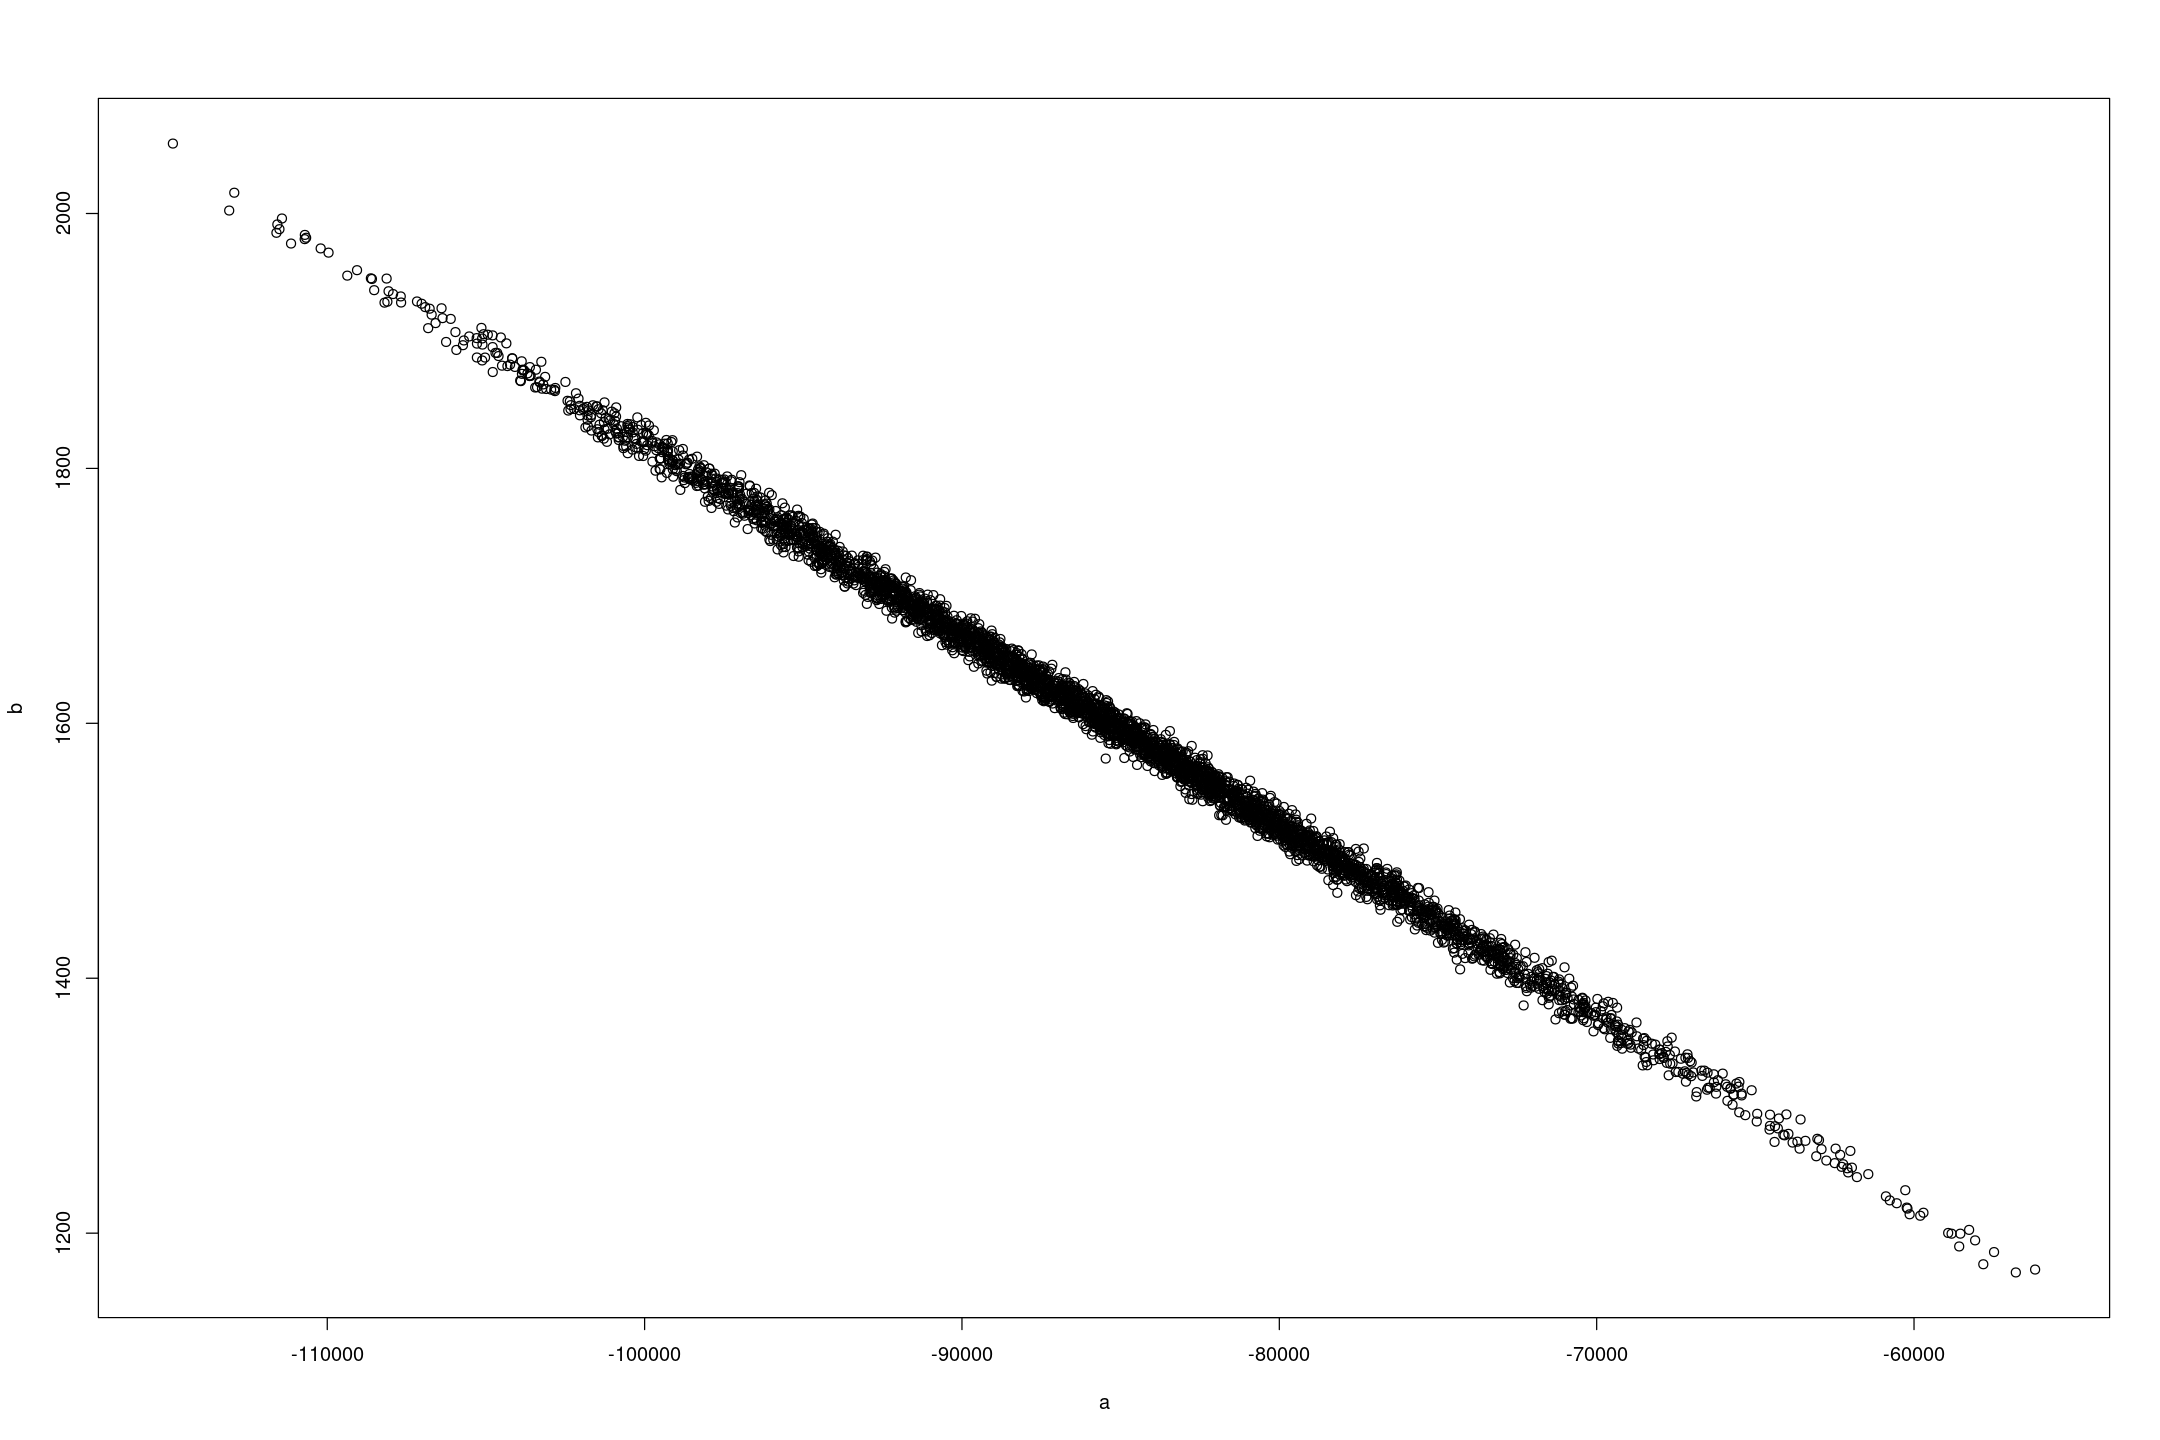

In [69]:
sims <- as.data.frame(earnings_model_uniform)
a <- sims[,1]
b <- sims[,2]

plot(a,b)

## Weakly informative

Now we use the default priorprior distribution

In [70]:
earnings_model_default <- stan_glm(earn ~ height, data=earnings, refresh=0)

Similar estimates

In [71]:
earnings_model_default

stan_glm
 family:       gaussian [identity]
 formula:      earn ~ height
 observations: 1816
 predictors:   2
------
            Median   MAD_SD  
(Intercept) -84956.5   9000.1
height        1594.1    135.4

Auxiliary parameter(s):
      Median  MAD_SD 
sigma 21693.2   347.1

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

The prior for the coefficient is 2.5 * sd(y) / sd(x)

In [72]:
2.5 * sd(earnings$earn) / sd(earnings$height)

[1] 14700.42

In [73]:
prior_summary(earnings_model_default)

Priors for model 'earnings_model_default' 
------
Intercept (after predictors centered)
  Specified prior:
    ~ normal(location = 21147, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 21147, scale = 56329)

Coefficients
  Specified prior:
    ~ normal(location = 0, scale = 2.5)
  Adjusted prior:
    ~ normal(location = 0, scale = 14700)

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 4.4e-05)
------
See help('prior_summary.stanreg') for more details

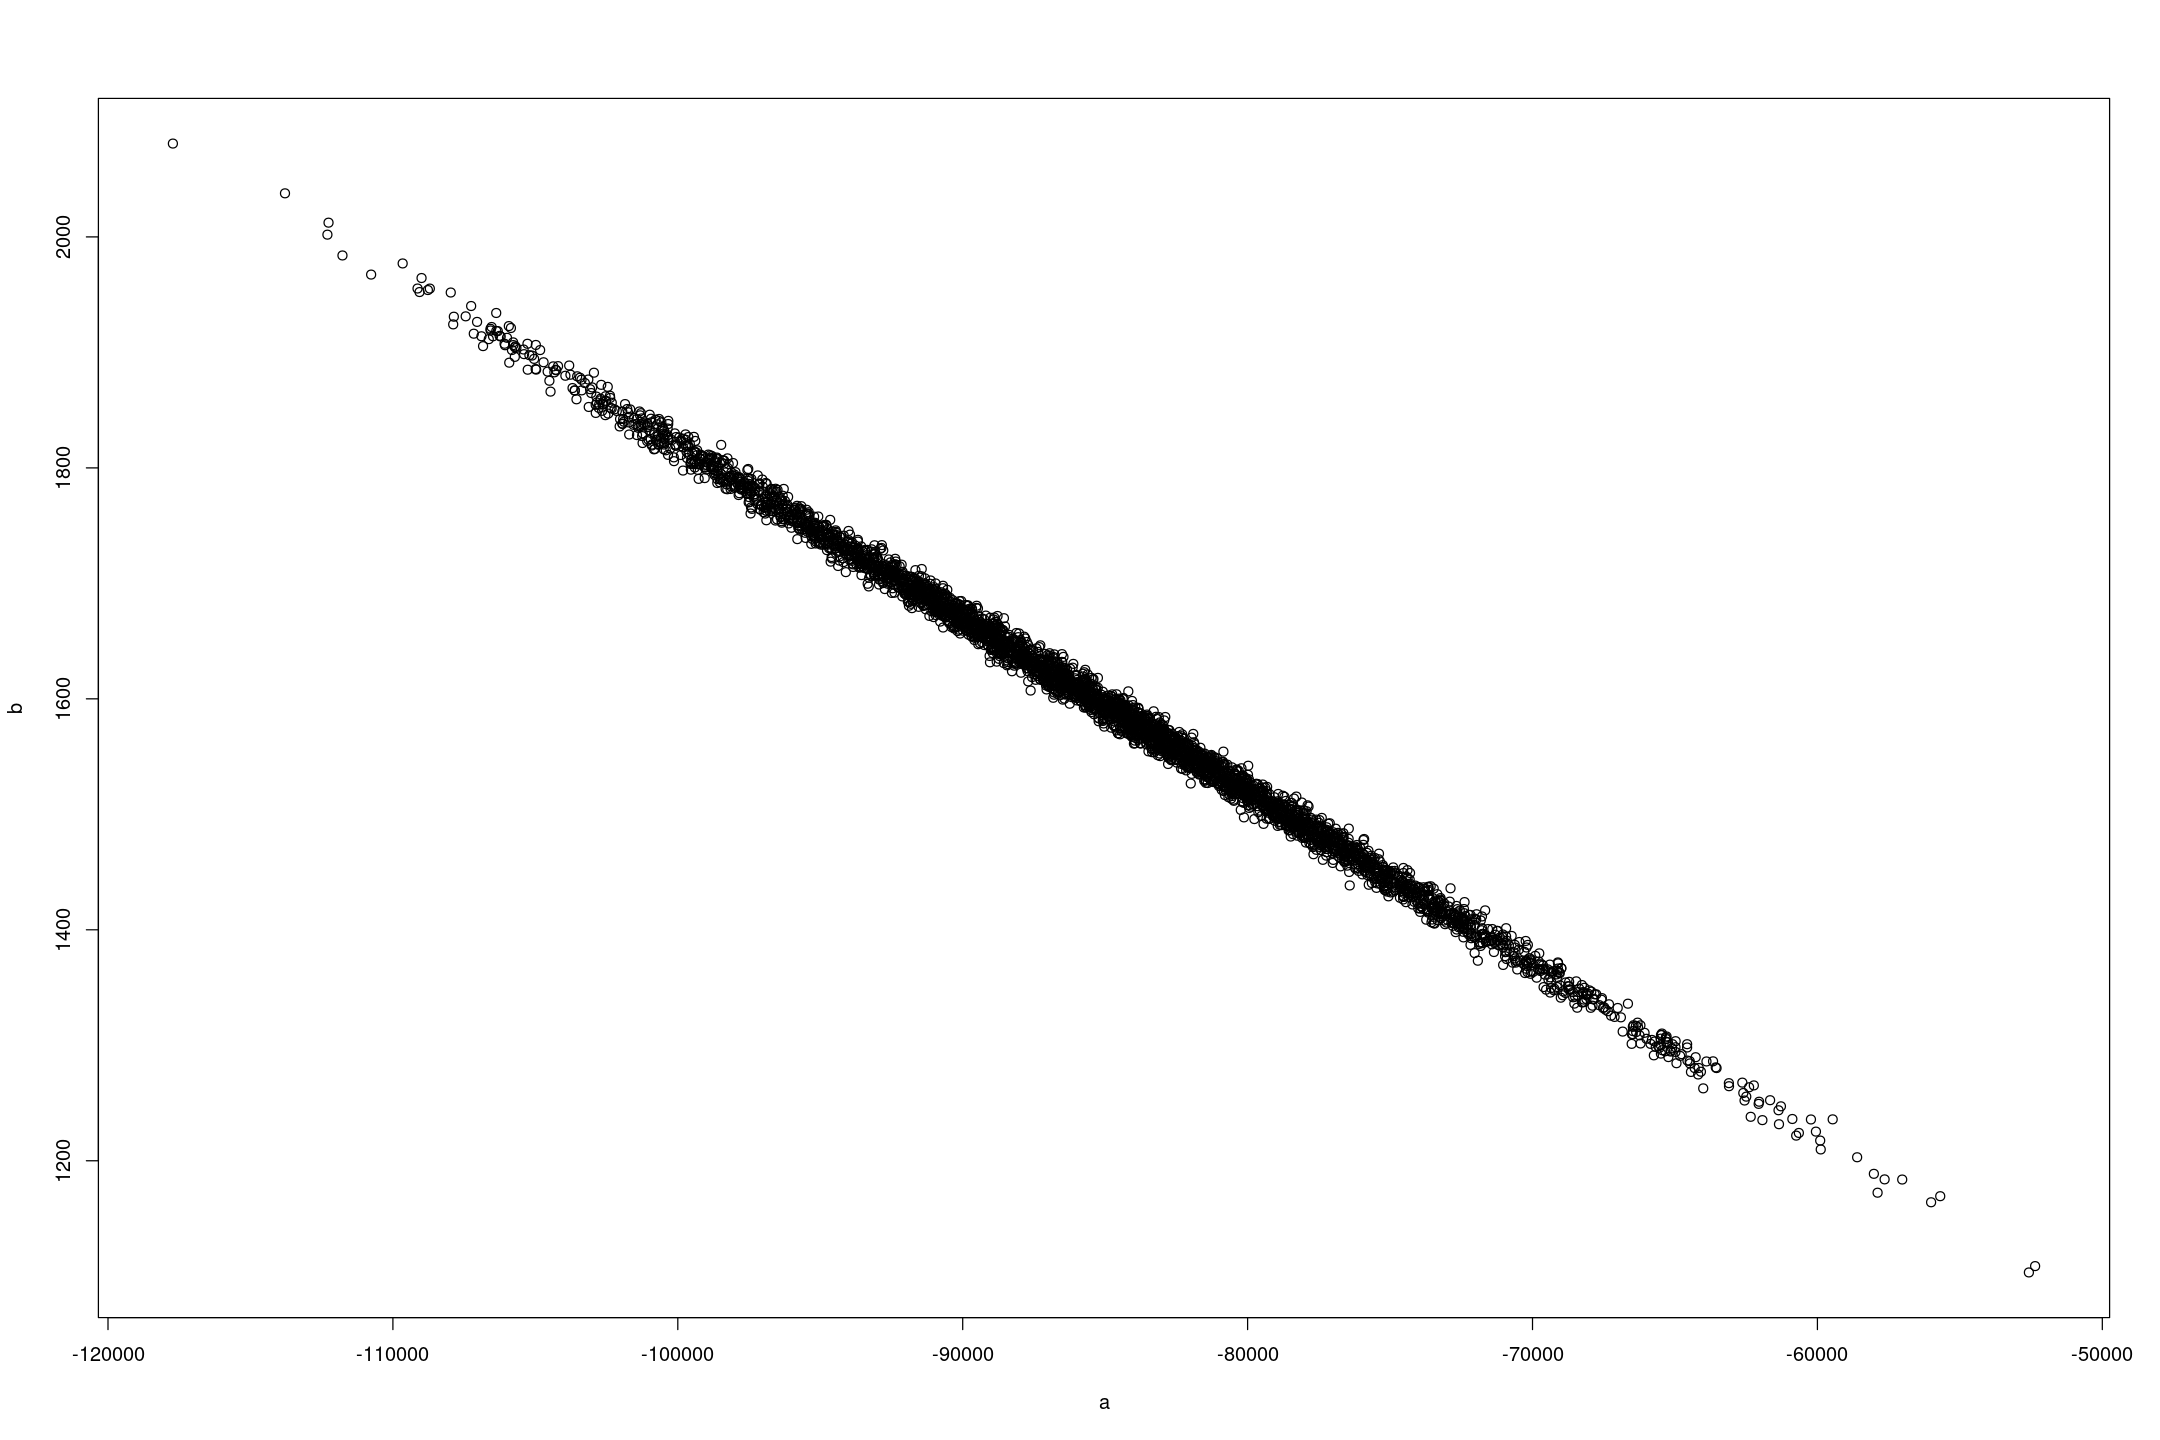

In [74]:
sims <- as.data.frame(earnings_model_default)
a <- sims[,1]
b <- sims[,2]

plot(a,b)

## Informative prior distribution

How do we expect earnings and height to be related?

Height is multimodal by gender; since we're not using gender as a predictor we have to combine the male and female distributions.
For American Males it's ~ 5'9" with sd of 3".
For American Females it's ~ 5'4" with sd of 3".


I would expect salary to be approximately lognormal.
The [US Personal Incomes](https://en.wikipedia.org/wiki/Personal_income_in_the_United_States) are around [\\$27,000](https://fred.stlouisfed.org/series/MEPAINUSA672N).
A reasonable range of earnings (around 90%) is \\$5,000 to \\$100,000.

For earnings we estimate the standard deviation

In [75]:
(log(100000) - log(5000)) / (2*1.645)

[1] 0.9105569

And the intercept

In [76]:
log(27000)

[1] 10.20359

In [77]:
exp(log(27000) + (log(100000) - log(5000)) / (2*1.645))

[1] 67114.08

In [78]:
exp(log(27000) - (log(100000) - log(5000)) / (2*1.645))

[1] 10862.1

Finally for our model:

There's likely some relation between height and earnings; for example males tend to be taller and tend to earn more than females.
But the effect is likley to be small: going up 5" of height (averag female to male height) might increase income by 10%, say around \\$3000.
So we could take a prior as `normal(0, 600)`.

The intercept is somewhat trickier.
At 5"7' the earnings should be about \\$27,000.
We could rebase the model to make this easier.

In [79]:
earnings$height_dev <- earnings$height - 67

In [80]:
mean(earnings$earn)

[1] 21147.3

In [81]:
sd(earnings$earn)

[1] 22531.77

The estimate of the coeffeicient is slightly lower, but the MAD_SD is about the same. 

In [82]:
earnings_model_informed <- stan_glm(earn ~ height_dev, data=earnings, refresh=0,
         prior = normal(0, 600), prior_intercept=normal(27000, 35000))

earnings_model_informed

stan_glm
 family:       gaussian [identity]
 formula:      earn ~ height_dev
 observations: 1816
 predictors:   2
------
            Median  MAD_SD 
(Intercept) 21803.1   501.5
height_dev   1518.5   130.4

Auxiliary parameter(s):
      Median  MAD_SD 
sigma 21696.0   363.3

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg

We can translate to get the actual intercept, which is slightly higher because of the prior

In [83]:
coef(earnings_model_informed)[[1]] - 67 * coef(earnings_model_informed)[[2]]

[1] -79933.98

# Simulation for decision analysis

An experiment is performed to measure the efficacy of a television advertising program.
The result is an estimate that each minute spent on a national advertising program will increase sales by \\$500 000, and this estimate has a standard error of \\$200 000.
Assume the uncertainty in the treatment effect can be approximated by a normal distribution.
Suppose ads cost \\$300 000 per minute.
What is the expected net gain for purchasing 20 minutes of ads?
What is the probability that the net gain is negative?

Let's put the variables in thousands of dollars

In [84]:
revenue_per_min_mean <- 500
revenue_per_min_se <- 200
cost_per_min <- 300

mins <- 20

Expected net gain of purchasing 20 minutes of ads is just the expected revenue minus the actual costs: $4m

In [85]:
mins * (revenue_per_min_mean - cost_per_min)

[1] 4000

The probability the net gain is negative under this model is the probability that the costs per minute exceed the revenue per minute.

This can be calculated to be 16%.

In [86]:
pnorm(300, 500, 200)

[1] 0.1586553

We can check this with a simulation

In [87]:
mean((rnorm(10000, revenue_per_min_mean, revenue_per_min_se) - cost_per_min) < 0)

[1] 0.1625

# Prior distributions

Consider a regression predicting final exam score $y$ from midterm exam score $x$.
Suppose that both exams are on the scale of $0-100$, that typical scores range from $50-100$, that the correlation of midterm and final is somewhere in the range $0.5-0.8$, and that the average score on the final exam may be up to 20 points higher of lower than the average score on the midterm.

Given the above information, set up reasonable priors for the slope and the intercepts after centering.

In [88]:
(.8 - 0.5)/1.5

[1] 0.2

`y ~ b + a * x`

The correlation of midterm and final is somewhere in the range 0.5 to 0.8.
If we're really sure of this we could take `a ~ Uniform(min=0.5, max=0.8)`

A more conservative method would be to use a distribution that has values outside that range.
For example we could use a normal centred on the midpoint and divide the range by 1.5 (a bit under 90% interval) to get a standard deviation estimate `a ~ Normal(0.65, 0.2)`

After centering again if we took 20 points higher or lower literally we could take `Intercept ~ Uniform(min=-20, max=20)`.
But a bit more conservative would be to take this as a 95% interval on a Normal distribution: `Intercept ~ Normal(0, 10)`.
Of course this can produce some impossible values (e.g. above 100 or below -100), but these are very unlikely to actually occur.

# Prior distribution and likelihood

Consider the model, $y = a + bx + \rm{error}$, with predictors $x$ uniformly samples from the range $(-1, 1)$, independent prior distributions for the coefficients $a$ and $b$, and the default prior distribution for the residual standard deviation $\sigma$.
For $a$, assume a normal prior distribution with mean 0 and standard deviation 1; for b, assume a normal prior distribution with mean 0 and standard deviation 0.2.

## Simulation

Simulate $n = 100$ data points from this model, assuming the true parameter values are $a=1,\ b=0.1,\ \sigma=0.5$.
Compute the least squares estimate of $a, b$ and compare to the Bayesian estimate obtained from `stan_glm` using the above priors.

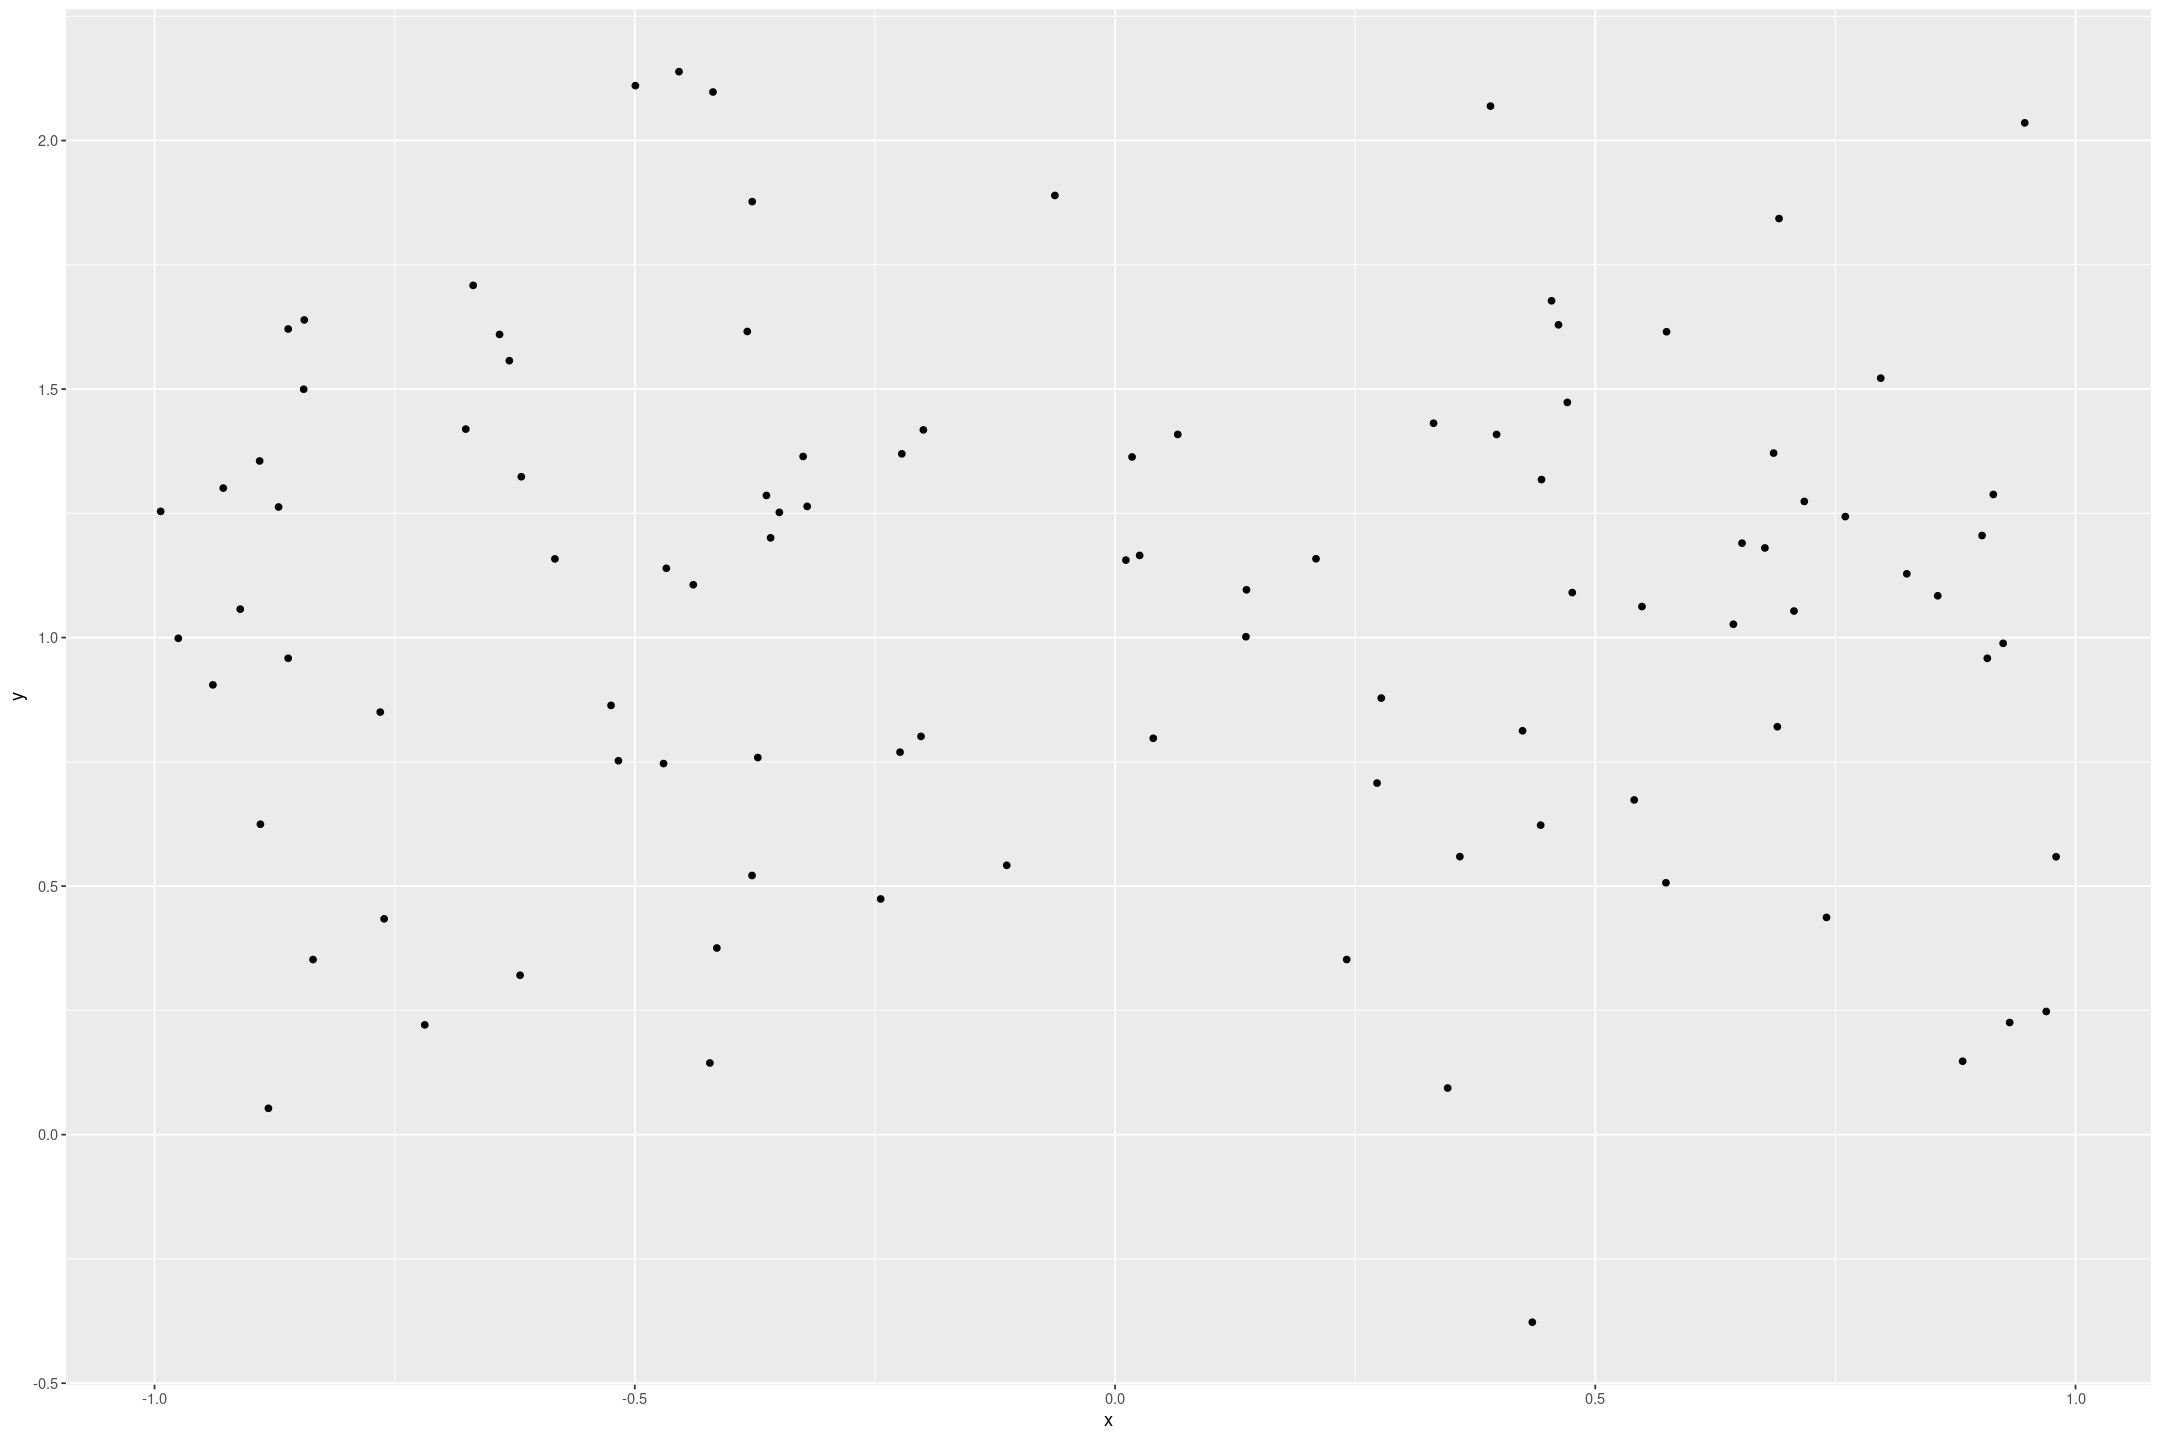

In [89]:
n <- 100

a <- 1
b <- 0.1
sigma <- 0.5

prior_a <- normal(0, 1)
prior_b <- normal(0, 0.2)

x <- runif(n, -1, 1)
y <- a + b*x + rnorm(n, 0, sigma)

fake_data <- data.frame(x=x, y=y)

gf_point(y ~ x)

In [90]:
lm(y ~ x, data=fake_data)


Call:
lm(formula = y ~ x, data = fake_data)

Coefficients:
(Intercept)            x  
    1.06873     -0.05037  


The intercept and sloper are slightly closer to 0

In [91]:
fake_model = stan_glm(y ~ x, data = fake_data, refresh=0,
        prior_intercept= prior_a, prior = prior_b)

print(fake_model, digits=3)

stan_glm
 family:       gaussian [identity]
 formula:      y ~ x
 observations: 100
 predictors:   2
------
            Median MAD_SD
(Intercept)  1.068  0.052
x           -0.043  0.076

Auxiliary parameter(s):
      Median MAD_SD
sigma 0.518  0.036 

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


## Effect of sample size

Repeat the simulations with different values of $n$.
Graph the Bayes estimates for $a$ and $b$ as a function of $n$.
What will these values be in the limit of $n=0$? $n=\infty$?

Theoretically we have:

$$ \hat{\theta}_{\rm{Bayes}} = \left.\left(\frac{\hat{\theta}_{\rm{prior}}}{\rm{se}^2_{\rm{prior}}} + \frac{\hat{\theta}_{\rm{data}}}{\rm{se}^2_{\rm{data}}}\right) \middle/ \left(\frac{1}{\rm{se}^2_{\rm{prior}}} + \frac{1}{\rm{se}^2_{\rm{data}}}\right) \right. $$

As $ n \rightarrow 0$ the effective standard error in the data estimate becomes infinite, and our estimates will be the prior; that is $ (a,b) \rightarrow (0,0) $.

As $n \rightarrow \infty$ the standard error in the data estimate goes to zero, and the unbiased estimator converges to the underlying means: $(a, b) \rightarrow (1, 0.1)$

In [92]:
fake_bayes_estimates <- function(n) {
    a <- 1
    b <- 0.1
    sigma <- 0.5

    x <- runif(n, -1, 1)
    y <- a + b*x + rnorm(n, 0, sigma)
    
    prior_a <- normal(0, 1)
    prior_b <- normal(0, 0.2)


    fake_data <- data.frame(x=x, y=y)

    fake_model <- stan_glm(y ~ x, data = fake_data, refresh=0,
          prior_intercept= prior_a, prior = prior_b)
    
    coef(fake_model)
}

In [93]:
ns <- seq(2, 200, by=2)

df <- vapply(ns, fake_bayes_estimates, double(2)) %>% as.data.frame()
names(df) <- ns

df$coef <- rownames(df)

df

Warning message:
“There were 135 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50,52,54,56,58,60,62,64,66,68,70,72,74,76,78,80,82,84,86,88,90,92,94,96,98,100,102,104,106,108,110,112,114,116,118,120,122,124,126,128,130,132,134,136,138,140,142,144,146,148,150,152,154,156,158,160,162,164,166,168,170,172,174,176,178,180,182,184,186,188,190,192,194,196,198,200,coef
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
(Intercept),1.448679826,1.462608,0.850993396,0.7212974,1.1579169,1.0867497,1.0766176,0.958033125,0.97753155,0.90290281,0.9205785,0.8820049,0.95598920,1.04225317,1.028901796,0.879640423,0.927976679,1.00544566,1.09768698,0.9758814,0.97249729,0.9635288,1.04658443,1.06553051,0.91942998,0.9639292,1.051235,1.00165226,0.89883569,1.0377946,0.9666207,1.1243313,0.9890406,1.04583416,0.98087925,0.8934640,1.15422822,1.0488272,1.0829953,0.99476172,1.0496441,1.02647192,1.0109357,0.9782274,0.969226,0.92874158,0.96612801,1.04457427,0.96657537,0.9545024,0.98055992,0.97819564,0.9706602,0.9971242,0.9675410,0.9918201,0.947044939,0.99881352,1.0068985,1.07097728,0.98255025,1.01092135,0.9660473,0.9748002,1.03432658,1.0050137,0.9544165,0.9470125,0.957648178,1.0698379,1.02368447,1.0567229,0.985619599,1.03279506,1.00780748,0.98824580,0.93248622,1.011544857,0.9952730,0.95465412,0.98517667,0.97889977,1.05032481,1.00496729,1.0101918,1.0511971,1.00210131,1.0155459,0.9892503,1.0520206,0.99836878,1.0390497,0.9947457,1.055851,0.94006194,1.016483636,0.94300579,1.0203290,1.04662682,0.96914611,(Intercept)
x,-0.006732074,0.167714,-0.008828662,0.2142055,0.0508302,0.1285172,-0.1529019,-0.007503778,0.02187564,0.09754337,-0.0614977,-0.1372288,0.06011685,0.05135797,-0.004797031,0.008985882,-0.008511528,0.05766994,-0.01719285,0.1474352,0.07141707,-0.1233984,0.08835089,-0.05458923,0.07031868,0.1554943,0.245497,0.03274332,0.07969426,0.1394833,0.1185576,0.1675868,0.0575309,-0.03893551,0.06387769,0.2372291,-0.07718654,0.1310463,0.1487192,0.06837467,0.2227924,-0.01503798,0.1206888,0.1196705,0.176461,0.02795199,-0.01530798,0.01294798,0.05477377,0.1045692,0.09598807,0.06063639,0.1389487,0.1098091,0.1579988,0.1030078,-0.009774755,0.01326355,0.1448291,0.08953617,0.08596321,0.04966931,0.1483355,0.1396205,0.03499548,0.2207521,0.1223688,0.1187706,-0.002989899,0.1255335,-0.01509356,0.1072974,0.002812356,0.05689445,0.05082011,0.08468363,0.01295772,-0.008872761,0.1022419,0.04624623,0.07557333,0.06068522,0.06612202,0.05856311,0.1110937,0.1012146,0.06186726,0.1161575,0.1667119,0.2123522,0.06697513,0.1038433,0.0288145,0.118654,0.08429112,0.005246824,0.09908308,0.1165456,0.03452381,-0.02037596,x


The intercept acts as expected: for small values it is 0, and quickly converges to 1.0

The slope is a bit noisier, especially for small n, but looks like it conforms to expectations.

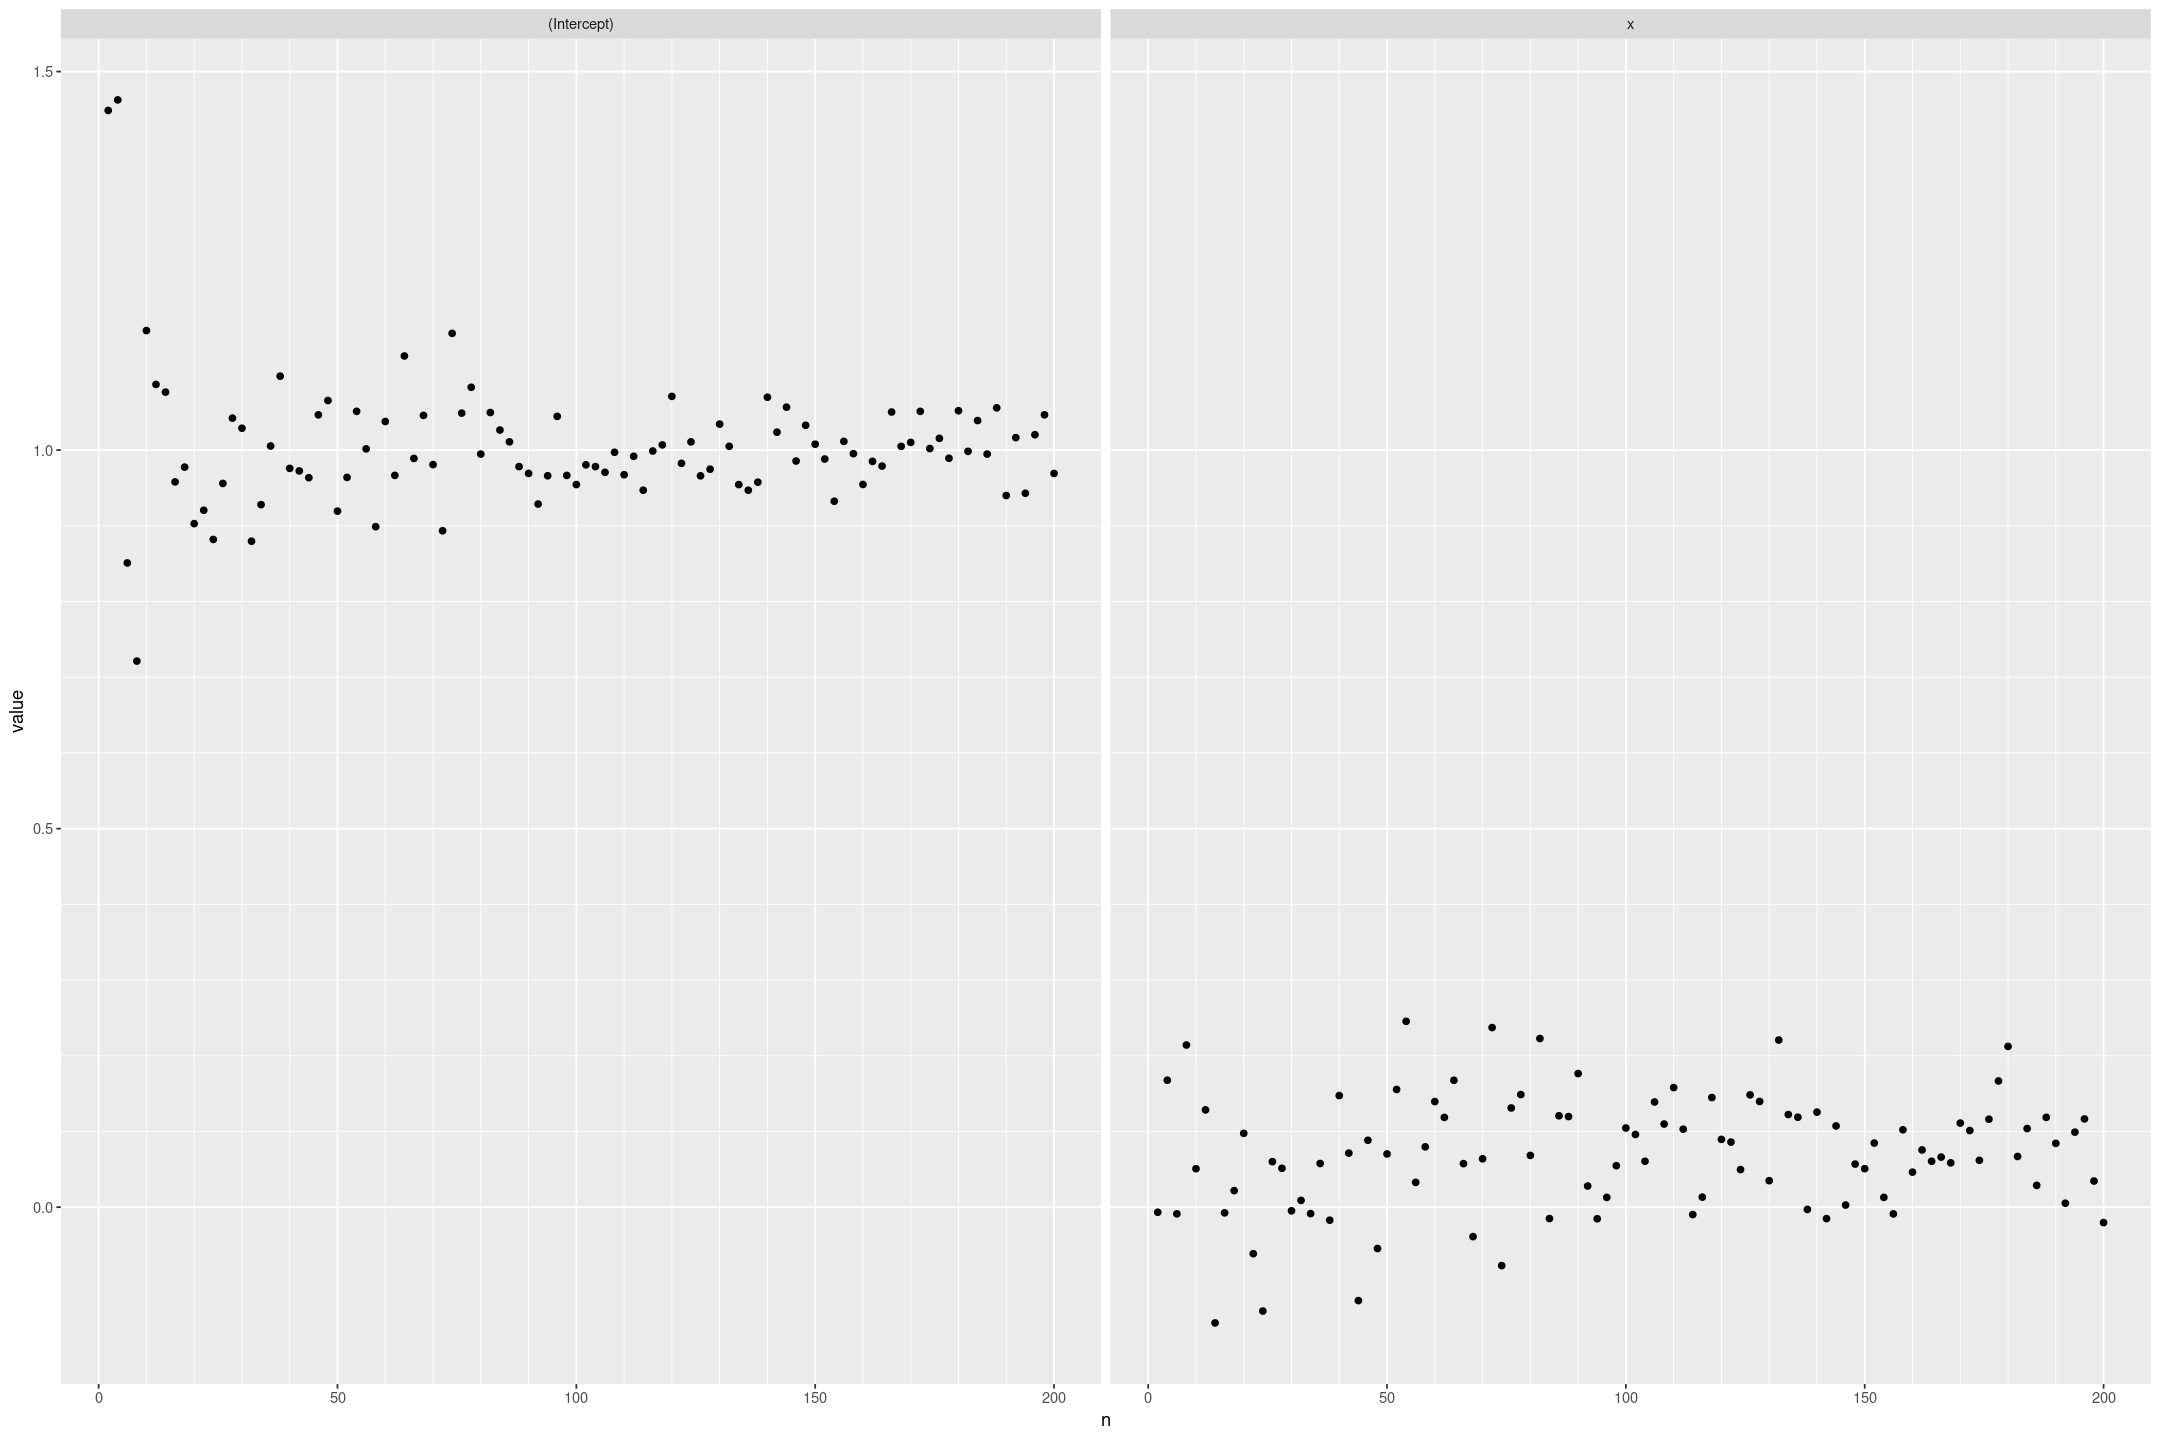

In [94]:
df_long <- pivot_longer(df, cols=as.character(ns), names_to = 'n') %>% mutate(n = as.double(n))

df_long %>% gf_point(value ~ n | coef, scales="free_y") + 
scale_y_continuous(minor_breaks=seq(0,1,by=0.1)) + 
scale_x_continuous(minor_breaks=seq(0, 200, by=10))

For the slope we could fit a model to try to see through the noise

In [95]:
slope_model <- stan_glm(value ~ n, data = df_long %>% filter(coef == 'x'), refresh=0)

print(slope_model, digits=5)

stan_glm
 family:       gaussian [identity]
 formula:      value ~ n
 observations: 100
 predictors:   2
------
            Median  MAD_SD 
(Intercept) 0.04781 0.01555
n           0.00023 0.00013

Auxiliary parameter(s):
      Median  MAD_SD 
sigma 0.07758 0.00557

------
* For help interpreting the printed output see ?print.stanreg
* For info on the priors used see ?prior_summary.stanreg


The predictions are around 0.05 at one end, and 0.10 at the other; pretty close to our expectation.

In [96]:
predict(slope_model, newdata=data.frame(n=c(0,200)))

1          2 
0.04797658 0.09255687

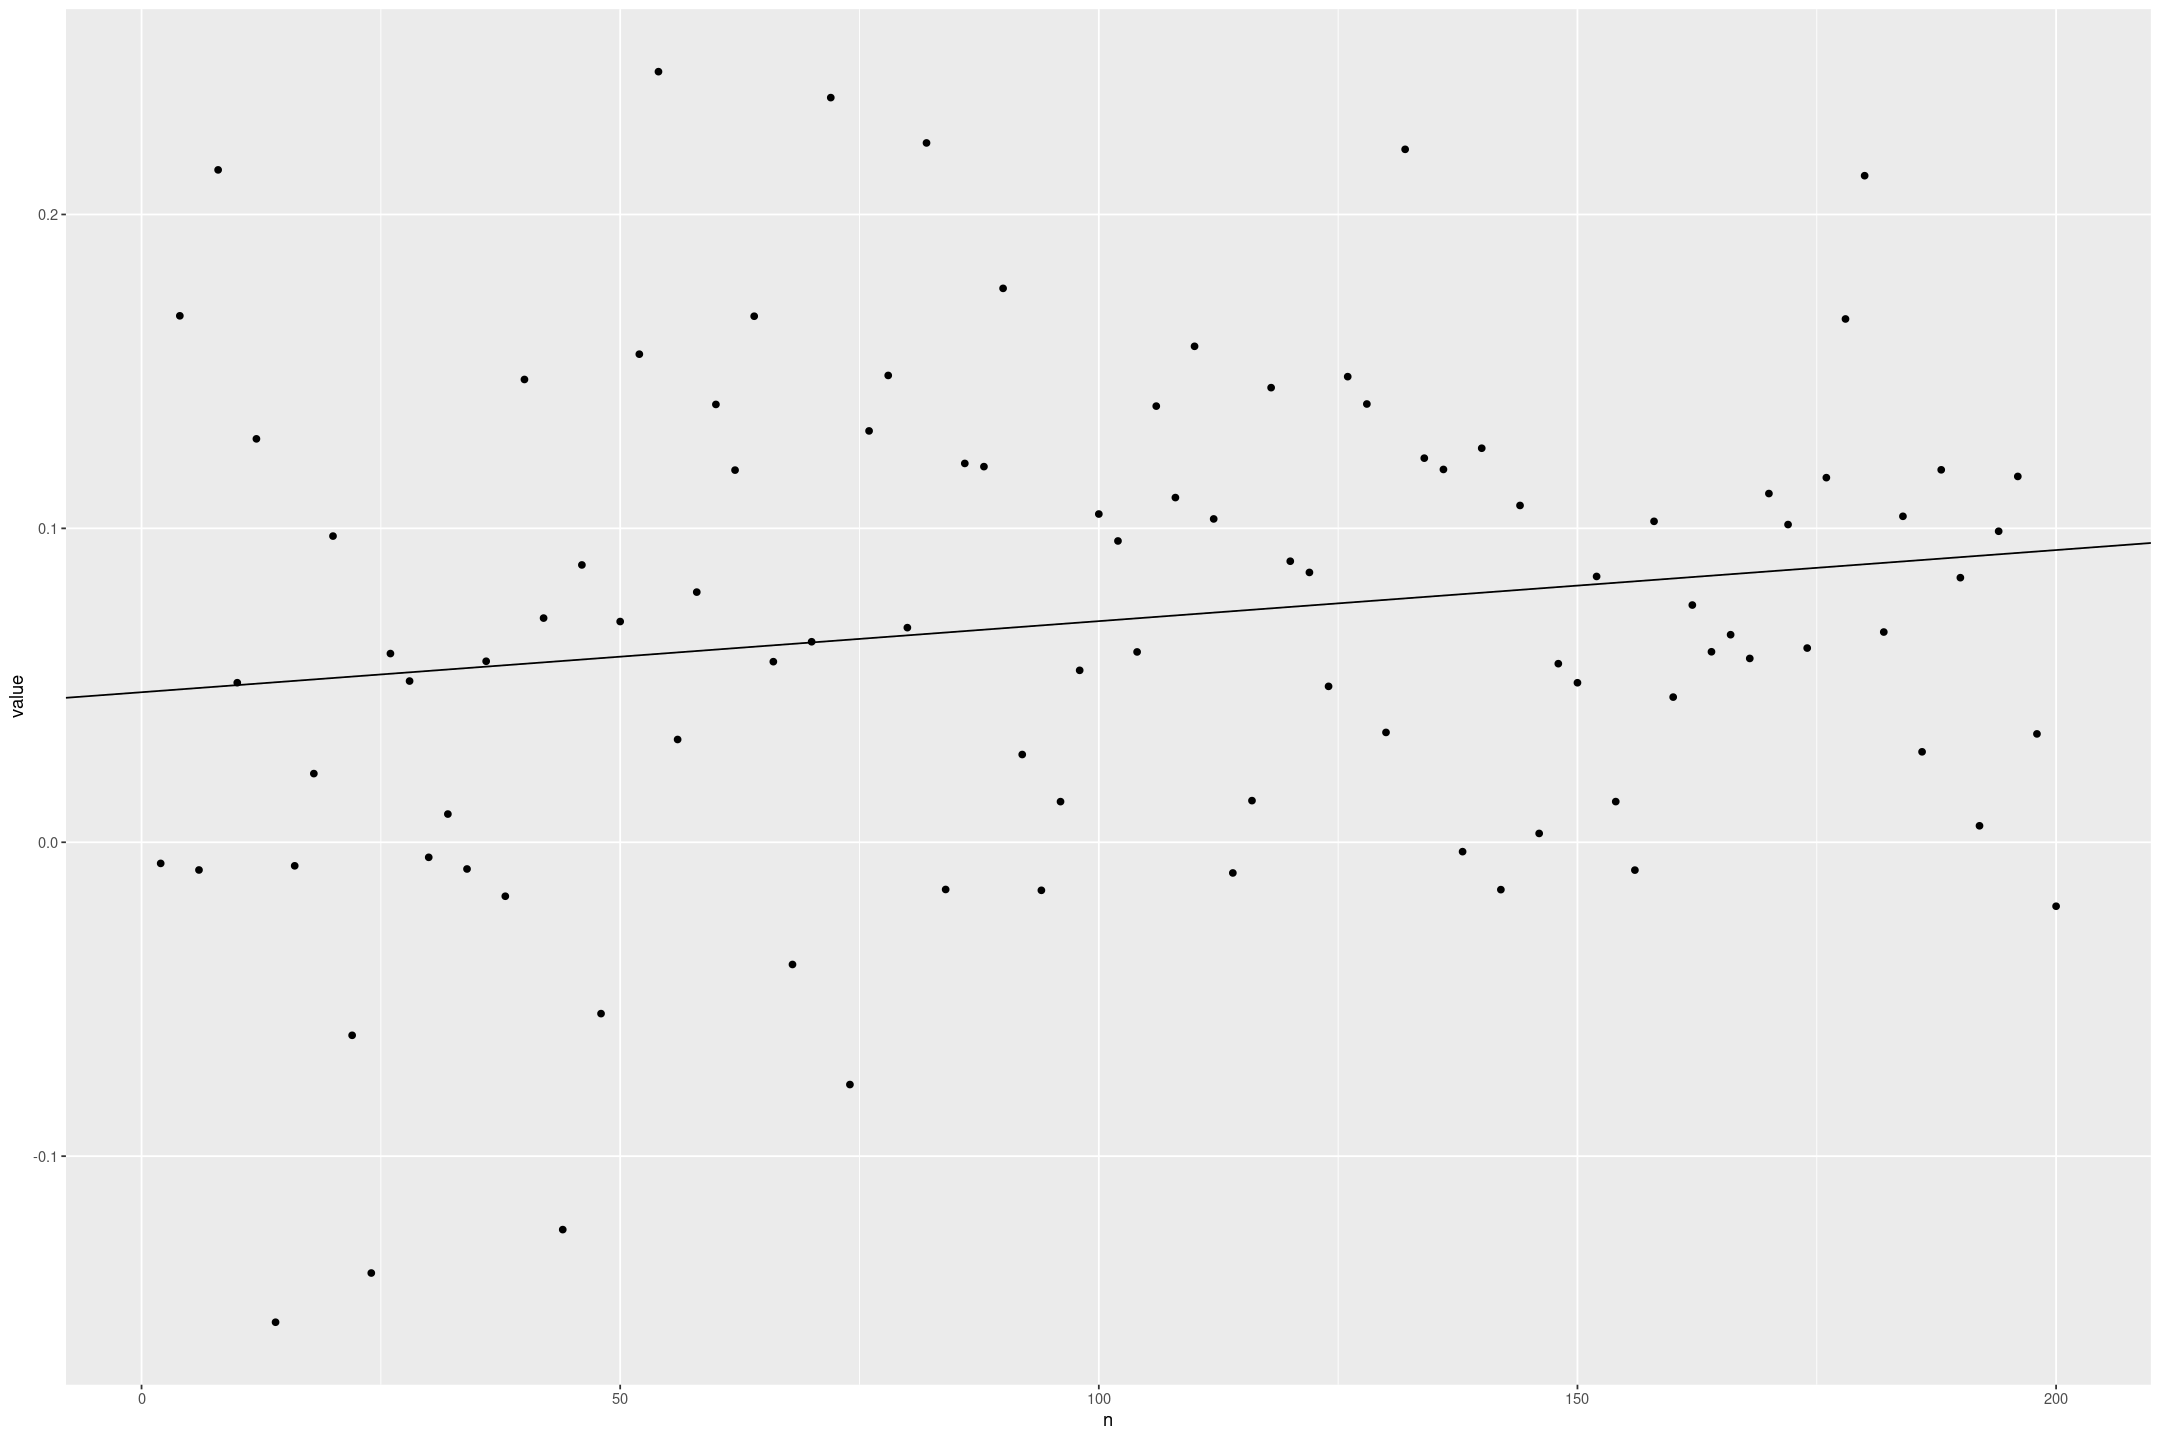

In [97]:
df_long %>% 
filter(coef == 'x') %>% 
gf_point(value ~ n) +
scale_y_continuous(minor_breaks=seq(0,1,by=0.1)) +
geom_abline(slope=coef(slope_model)[[2]], intercept=coef(slope_model)[[1]])

## Partial pooling

For what value of $n$ is the Bayes estimate for $a$ halfway between the prior mean and least squares estimate?
For what value of $n$ is the Bayes estimate for $b$ halfway between the prior mean and the least squares estimate?

By the Bayes estimate formula it's midway when the standard error for the coefficient is the same as that for the prior.

Our model is `y = a + bx + error` where `error` is drawn from a normal distribution with standard devation `sigma` and mean 0.
This is equivalent to saying `y ~ Normal(a + bx, sigma)`; that is y is from a normal distribution with centre `a+bx` and standard deviation `sigma`.

The Likelihood is then 

$$ L(\boldsymbol{y} \vert a, b, \sigma, \boldsymbol{x}) = \prod_{i=1}^{N} \frac{1}{\sqrt{2 \pi} \sigma} \exp\left({-\frac{1}{2} \left(\frac{a + bx_i - y_i}{\sigma}\right)^2}\right)$$

And the Negaetive Logliklihood

$$ - \ln L(\boldsymbol{y} \vert a, b, \sigma, \boldsymbol{x}) =  \frac{N}{2} \ln \left(2 \pi \right) + N \ln \sigma + \frac{1}{2} \sum_{i=1}^{N} \left(\frac{a + bx_i - y_i}{\sigma}\right)^2$$

Then the partial derivatives of this are

$$ - \frac{\partial \ln L}{\partial a}(\boldsymbol{y} \vert a, b, \sigma, \boldsymbol{x}) = \frac{1}{\sigma^2} \sum_{i=1}^{N} (a + bx_i - y_i) = \frac{N}{\sigma} (a + b \bar{x} - \bar{y}) $$

$$ - \frac{\partial \ln L}{\partial b}(\boldsymbol{y} \vert a, b, \sigma, \boldsymbol{x}) = \frac{1}{\sigma^2} \sum_{i=1}^{N} x_i (a + bx_i - y_i) = \frac{N}{\sigma} \left(\bar{x} (a + b \bar{x} - \bar{y}) + b \rm{Var}(x) - \rm{Cov}(x, y) \right)$$

So the log liklihood is maximised where $ \hat{b} = \frac{\rm{Cov}(x, y) }{\rm{Var}(x)} $ and $ \hat{a} = \bar{y} - b \bar{x} $.

The Hessian of the negative logliklihood (treating $\sigma$ as a constant) is then

$$   \frac{N}{\sigma^2} \begin{bmatrix}
           1 & \bar{x} \\
           \bar{x} & \rm{Var}(x) - {\bar{x}}^2
      \end{bmatrix}
 $$


So I would expect $ \hat{\rm{se}_a} \approx \frac{\sigma}{\sqrt{N}} $.
For `Unif(-1, 1)` the mean is 0 and the variance is $ \frac{\int_{-1}^{1} x^2}{\int_{-1}^{1} 1} = \frac{1}{3} $.
So $ \hat{\rm{se}_b} \approx \frac{\sqrt{3}\sigma}{\sqrt{N}} $

Putting this all together I would expect equal contribution for a where $$ N = \left(\frac{\sigma}{\rm{se}_a}\right)^2 = \left(\frac{0.5}{1}\right)^2 = 0.25 $$

For b it is where $$ N = 3 \left(\frac{\sigma}{\rm{se}_b}\right)^2 = 3 \left(\frac{0.5}{0.2}\right)^2 = 18.75 $$

It's going to be hard to see equal contributions from a, but we can see equal contributions from b at around 19.

Here we expect that a will be very close to 1

In [98]:
n19 <- vapply(rep(19, 100), fake_bayes_estimates, double(2))

`a` peaks strongly around 1

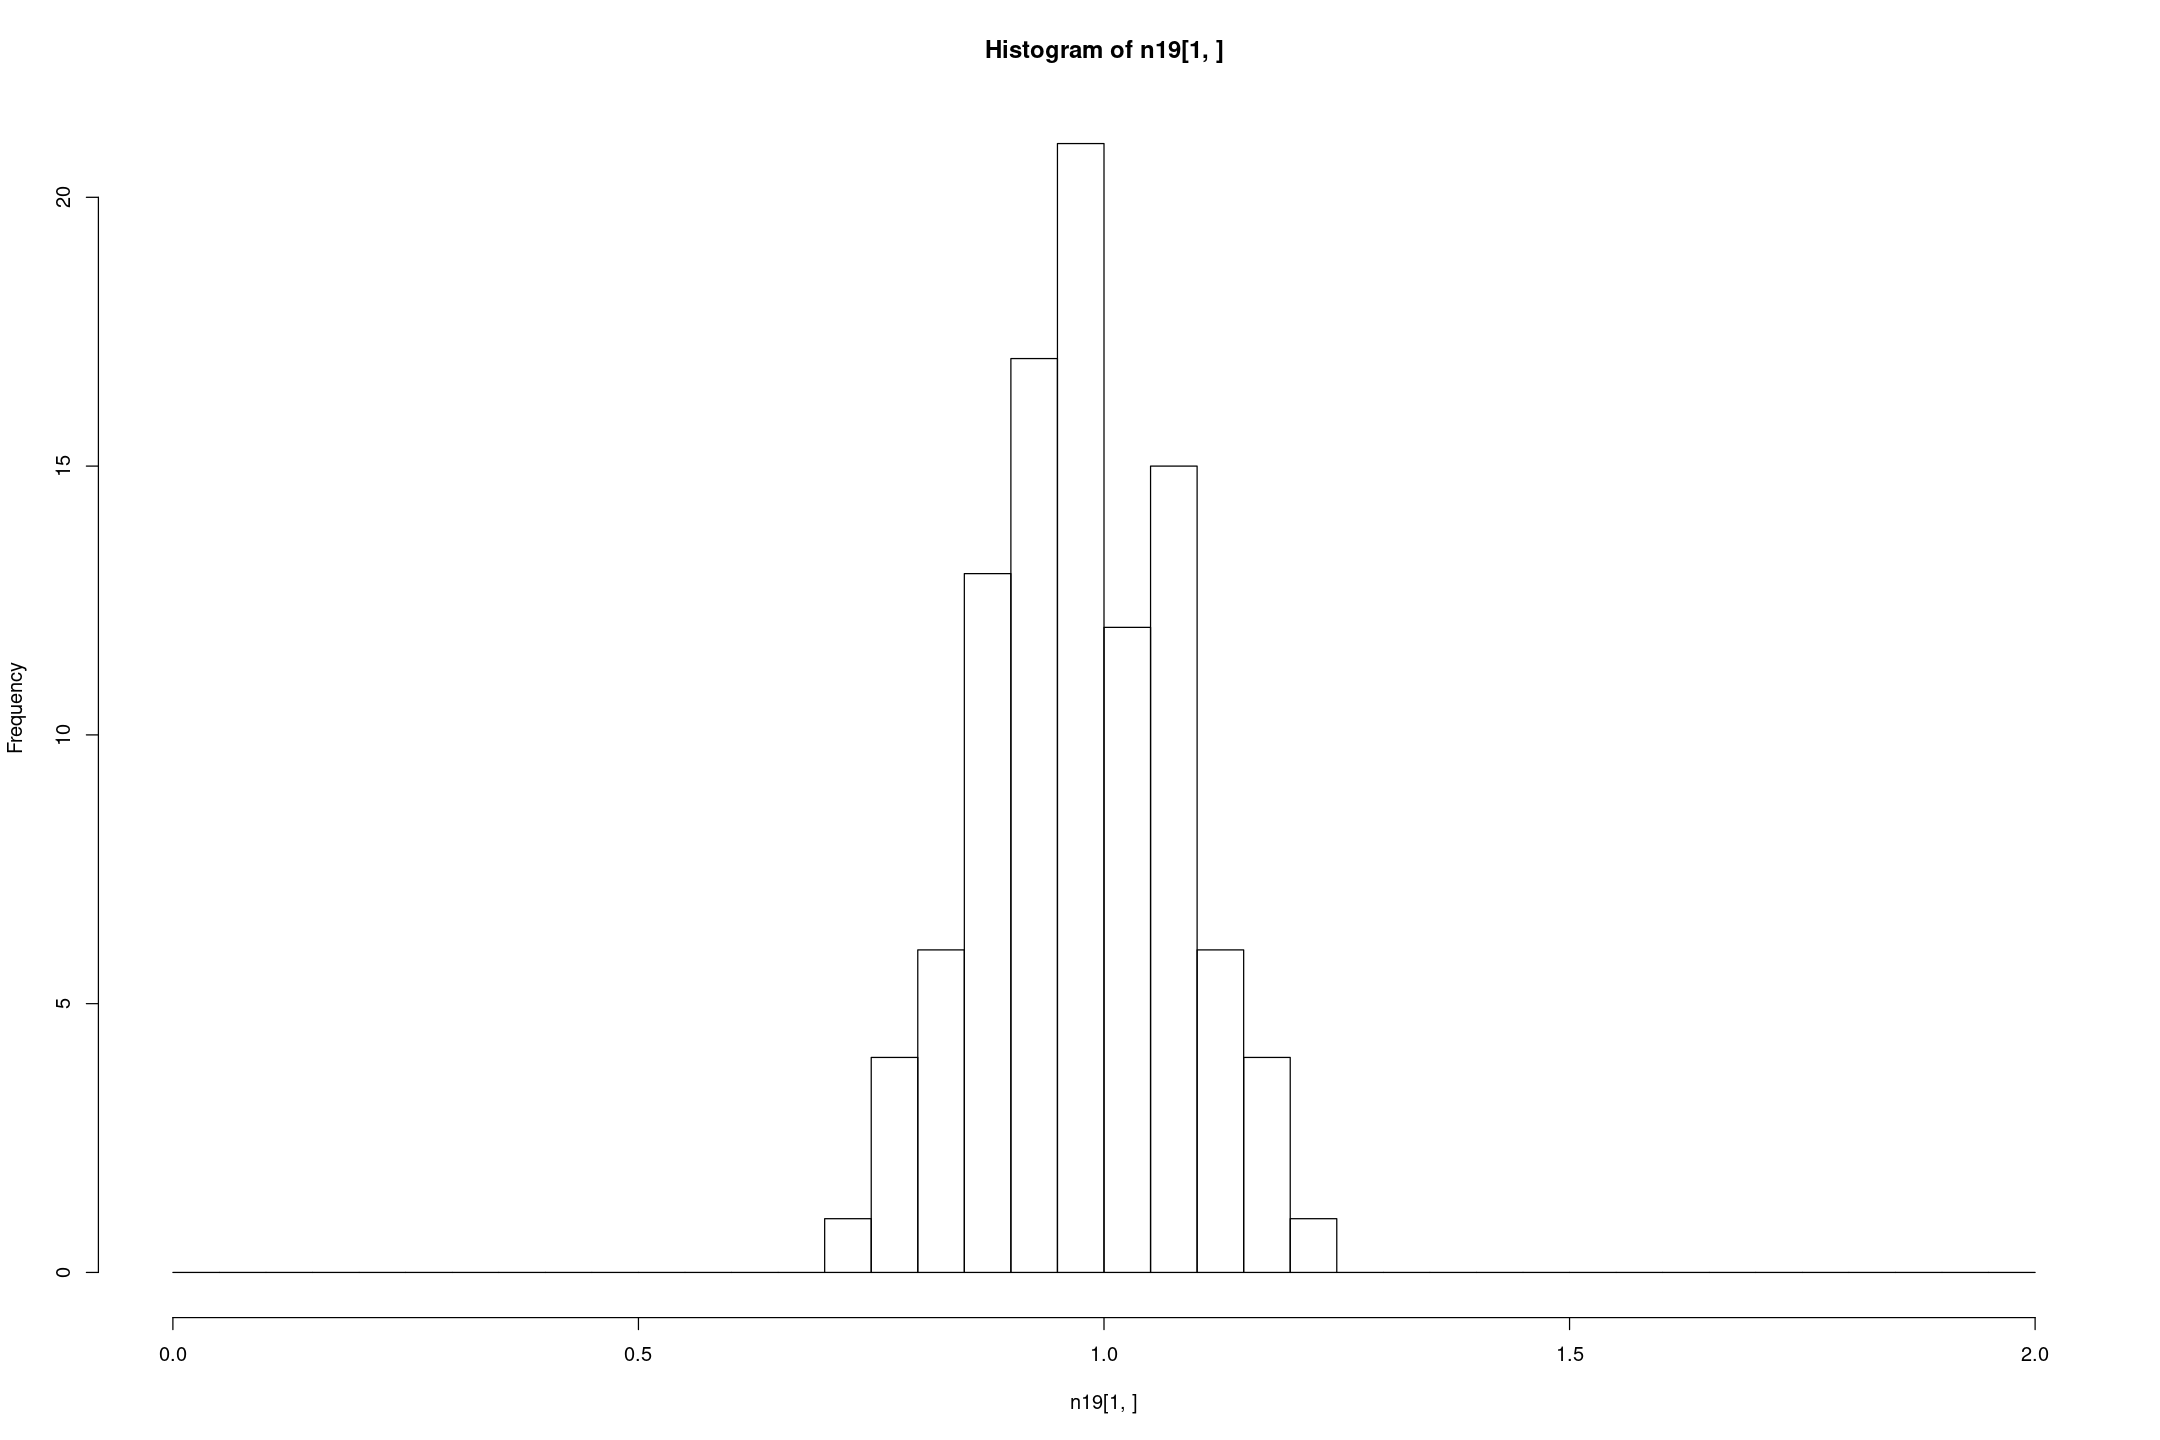

In [99]:
hist(n19[1,], breaks=seq(0, 2, by=0.05))

In [100]:
median(n19[1,])

[1] 0.9784642

In [101]:
mean(n19[1,])

[1] 0.9757743

Our esimtate for b is a around halfway between 0 and 0.2, a little higher.

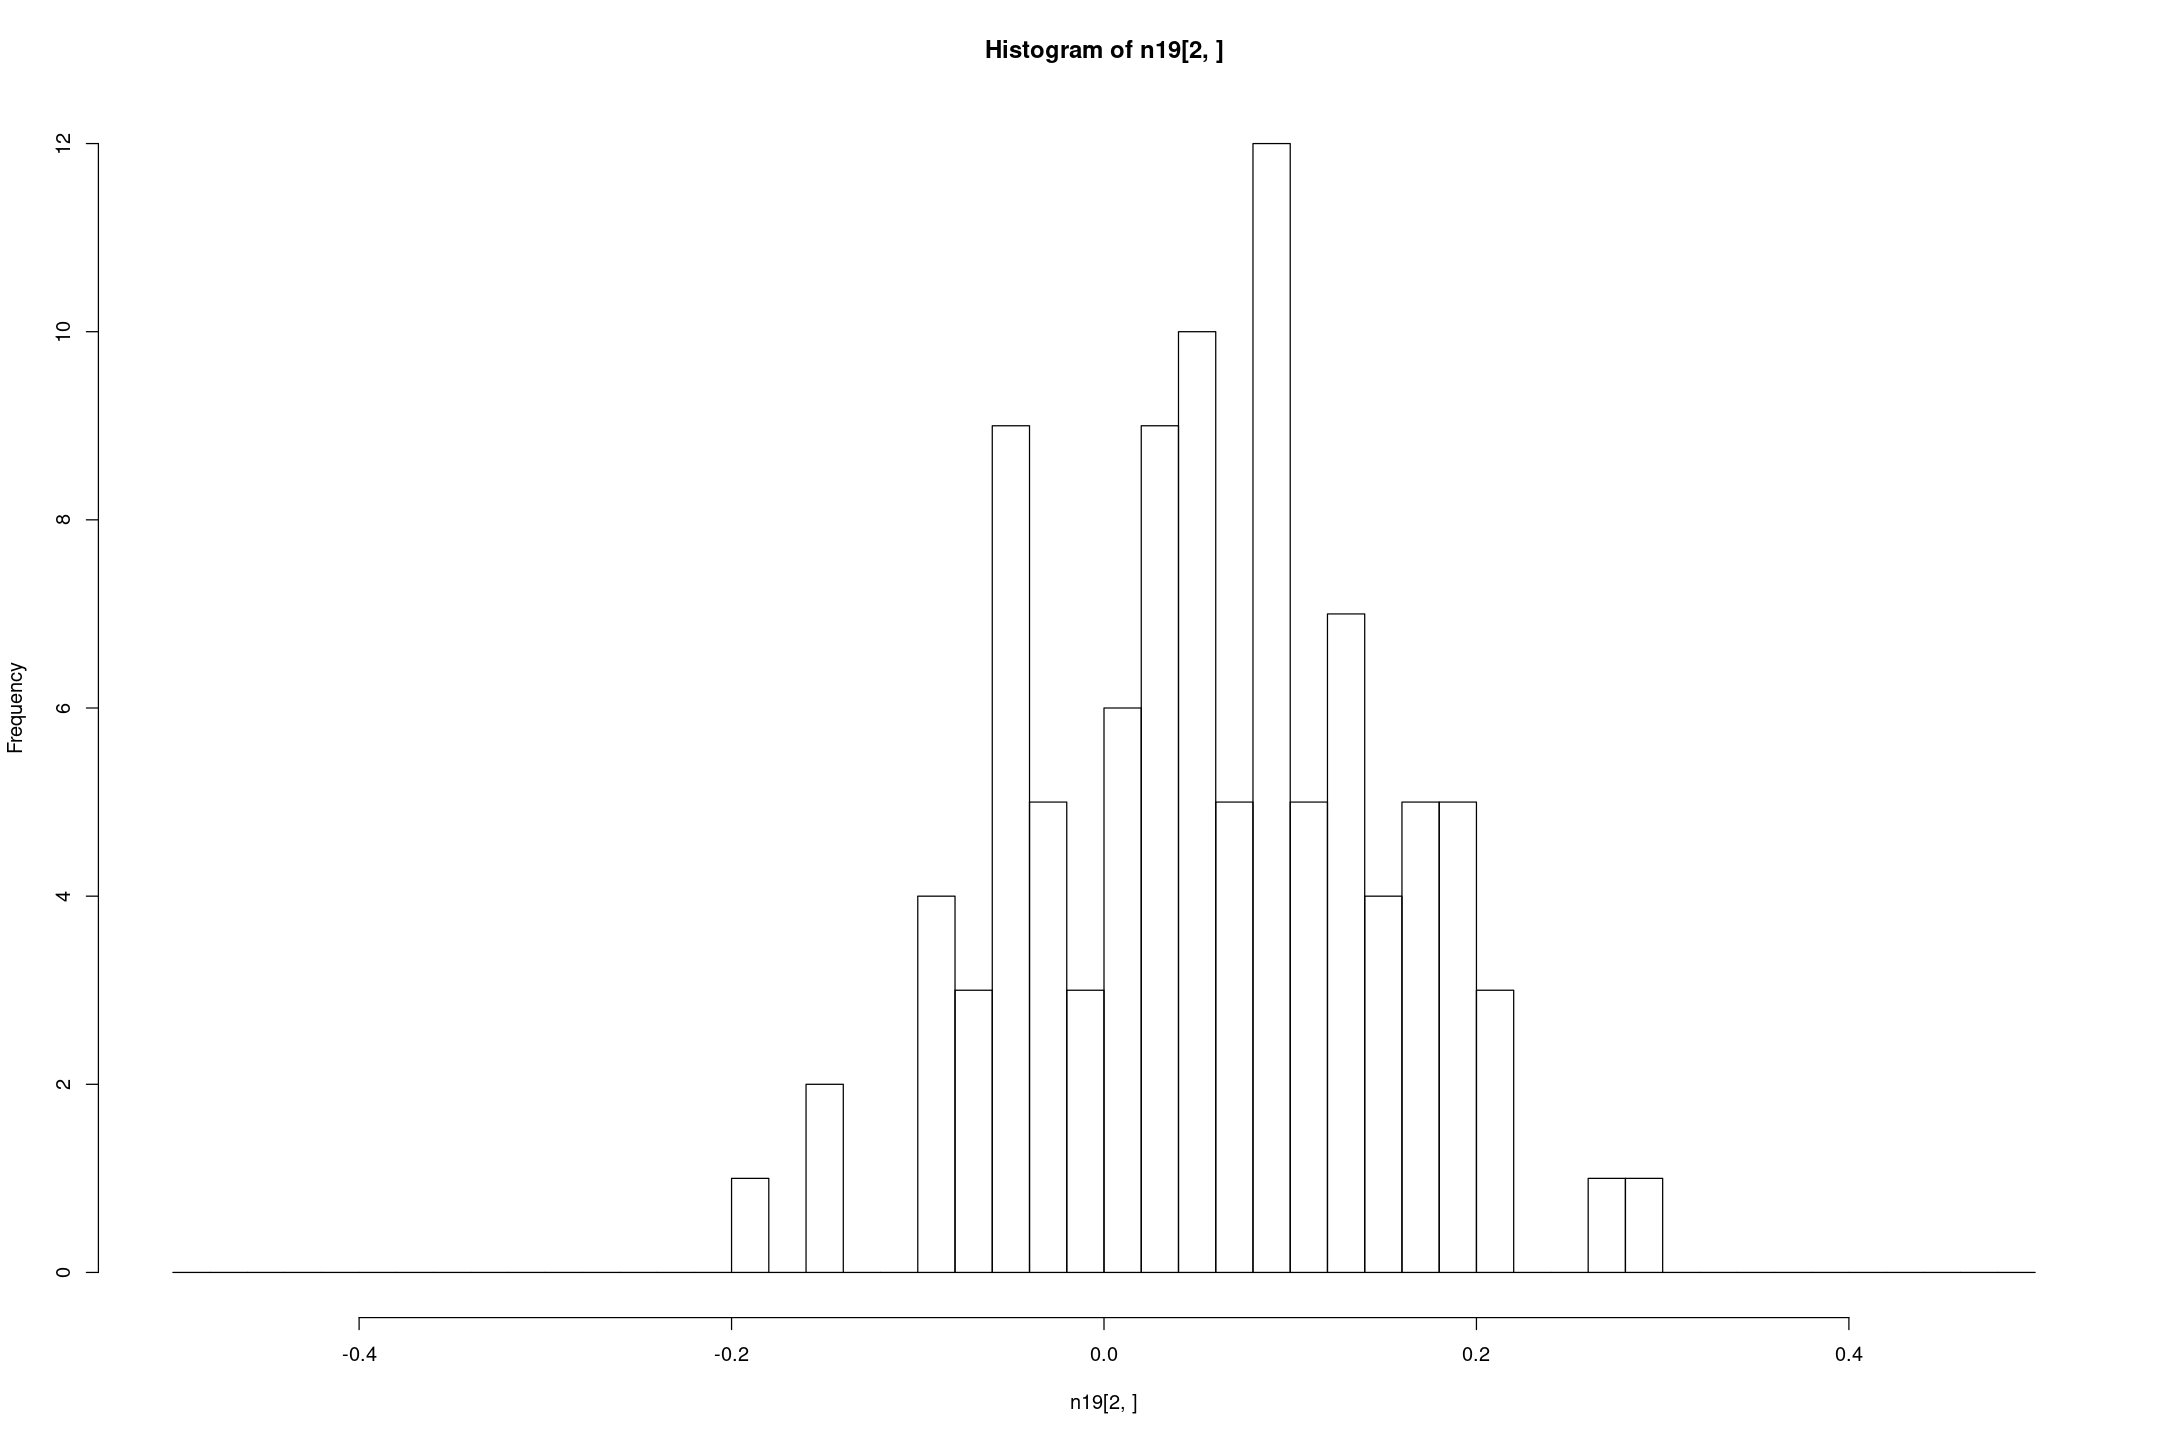

In [102]:
hist(n19[2,], breaks=seq(-0.5, 0.5, by=0.02))

In [103]:
median(n19[2,])

[1] 0.05418393

In [104]:
mean(n19[2,])

[1] 0.0560454